### Data Loader and Preprocessor:
Purpose: Handles data loading, preprocessing, and splitting into train/test sets.
Methods: Load data, preprocess data, split data.

### Analysis and Statistics:
Purpose: Provides statistical analysis and reporting on the dataset.
Methods: General stats, null rate calculation, metadata contribution and more..

### Visualization:
Purpose: Creates visualizations for data exploration and results.
Methods: Plot distributions, spam vs non-spam visualizations.

### Project manager + models:
Purpose: Contains general utility functions that may be useful across the project.
Methods: Save models, load models, export results.

### [link to git ](https://github.com/snirdav/project_group_9/tree/main)


# Part A

## 1. Imports

In [ ]:
!pip install datasets
!pip install pytorch_lightning
!pip install torch torchvision

# pip install memory_profiler
# pip install xgboost==1.6.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 4.8 MB/

In [ ]:
# Standard library imports
print("Script started")
import os
import warnings

# Data manipulation and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLTK for text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Sklearn for classic machine learning and preprocessing
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

# TextBlob for sentiment analysis
from textblob import TextBlob

# PyTorch and related utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils.prune as prune
import torch.quantization
from torch.utils.data import DataLoader, Dataset, TensorDataset

# PyTorch Lightning
import pytorch_lightning as pl
import torchmetrics

# Transformers and Datasets for NLP models
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from datasets import Dataset

# TensorFlow and Keras for additional deep learning models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# XGBoost for gradient boosting
import xgboost as xgb

# Working with Google Colab (if applicable)
from google.colab import drive
print("Imports part is finished")


Script started
Imports part is finished


## 2. Classes

### Data Loader & Preprocessor



In [ ]:
class DataLoaderAndPreprocessor:
    def __init__(self, data_path):
        # Initializing with the data path
        self.data_path = data_path
        self.raw_df_dict = self.load_data_from_dir()  # Loading data from directory
        self.original_data_dict = self.raw_df_dict.copy()  # Backing up original data

    def load_data(self, file_name):
        # Loading individual CSV file
        df = pd.read_csv(f"{self.data_path}/{file_name}")
        print(f"Loaded {file_name} with shape: {df.shape}")
        return df

    def load_data_from_dir(self):
        # Loading all CSV files from directory
        data_dict = {}
        for file_name in os.listdir(self.data_path):
            if file_name.endswith('.csv'):
                data_dict[file_name] = self.load_data(file_name)
        print(f"Data loaded from directory: {list(data_dict.keys())}")
        return data_dict

    def concat_dataframes(self, exclude_df_name):
        # Concatenating DataFrames, excluding one specified
        all_columns = set()

        # Collecting all columns from DataFrames except the one to exclude
        for df_name, df in self.raw_df_dict.items():
            if df_name != exclude_df_name:
                all_columns.update(df.columns)

        all_columns = list(all_columns)
        print(f"Columns being used for concatenation: {all_columns}")

        # Ensuring each DataFrame has all columns, filling missing ones with NaN
        def ensure_columns(df, columns, source_name):
            for col in columns:
                if col not in df.columns:
                    df[col] = np.nan
            df['source'] = source_name
            return df[columns + ['source']]

        # Preparing and concatenating DataFrames excluding the specified one
        concatenated_df = pd.DataFrame(columns=all_columns + ['source'])
        for df_name, df in self.raw_df_dict.items():
            if df_name != exclude_df_name:
                print(f"Before concatenation {df_name} shape: {df.shape}")
                df = ensure_columns(df, all_columns, df_name)
                concatenated_df = pd.concat([concatenated_df, df], ignore_index=True)
                print(f"After concatenation {df_name} concatenated_df shape: {concatenated_df.shape}")

        print(f"Final shape of concatenated_df: {concatenated_df.shape}")
        return concatenated_df

    def preprocess_data(self, df):
        # Preprocessing data through multiple steps
        print(f"Initial shape of df in preprocess_data: {df.shape}")
        df = self.handle_missing_values(df)
        print(f"Shape after handling missing values: {df.shape}")
        df = self.handle_outliers(df)
        print(f"Shape after handling outliers: {df.shape}")
        df = self.normalize_features(df)
        print(f"Shape after normalizing features: {df.shape}")
        df = self.encode_features(df)
        print(f"Shape after encoding features: {df.shape}")
        df = self.convert_datetime(df)
        print(f"Shape after converting datetime: {df.shape}")
        df = self.text_preprocessing(df)
        print(f"Shape after text preprocessing: {df.shape}")
        return df

    def handle_missing_values(self, df):
        # Handling missing values in 'subject' and 'body' columns
        df.loc[:, 'subject'].fillna('No Subject', inplace=True)
        df.loc[:, 'body'].fillna('No Body', inplace=True)
        return df

    def handle_outliers(self, df):
        # Handling outliers in 'urls' column
        if 'urls' in df.columns:
            df.loc[:, 'urls'] = df['urls'].clip(lower=df['urls'].quantile(0.01), upper=df['urls'].quantile(0.99))
        return df

    def normalize_features(self, df):
        # Normalizing 'urls' column
        if 'urls' in df.columns:
            scaler = StandardScaler()
            df.loc[:, ['urls']] = scaler.fit_transform(df[['urls']])
        return df

    def encode_features(self, df):
        # Encoding 'label' column
        if 'label' in df.columns:
            label_encoder = LabelEncoder()
            df.loc[:, 'label'] = label_encoder.fit_transform(df['label'])
        return df

    def convert_datetime(self, df):
        # Converting 'date' column to datetime
        if 'date' in df.columns:
            df.loc[:, 'date'] = pd.to_datetime(df['date'], errors='coerce', utc=True)
        return df

    def text_preprocessing(self, df):
        # Preprocessing text in 'body' column
        df.loc[:, 'body'] = df['body'].apply(self.clean_text)
        return df

    def clean_text(self, text):
        # Cleaning text by removing stopwords and non-alphanumeric characters
        text = text.lower()
        stop_words = set(stopwords.words('english'))
        tokens = word_tokenize(text)
        cleaned_text = ' '.join([word for word in tokens if word.isalnum() and word not in stop_words])
        return cleaned_text

    def preprocess_data_dict(self):
        # Preprocessing all DataFrames in the dictionary
        processed_dict = {}
        for key, df in self.raw_df_dict.items():
            processed_dict[key] = self.preprocess_data(df)
        return processed_dict

    @staticmethod
    def cast_columns(df, col_name, dtype):
      # Cast columns to appropriate types
      try:
        if col_name in df.columns:
          if dtype == 'date':
              df[col_name] = pd.to_datetime(df[col_name], errors='coerce', utc=True)
          else:
            df[col_name] = df[col_name].astype(dtype)
        return df
      except Exception as e:
        raise ValueError(f'see the {e}')

    def update_original_data(self):
        # Updating the backup of the original data
        self.original_data_dict = self.raw_df_dict.copy()

### AnalysisAndStatistics

In [ ]:
class AnalysisAndStatistics:
    def __init__(self, raw_df):
      self.raw_df = raw_df

    def df_general_stats(self) -> None:
      print(f"--- General Info ---\n")
      print(f"{self.raw_df.info()}\n")
      print(f"--- Statistics ---\n")
      print(f"{self.raw_df.describe()}\n")

    def nulls_rate_per_col(self, df_cols: list) -> None:
      for col in df_cols:
        nulls = self.raw_df[col].isnull().sum()
        df_length = self.raw_df.shape[0]
        calc = round(nulls / df_length * 100, 2)
        print(f"The null rate of {col} column: {calc}%")
        print(f"Number of nulls: {nulls}, number of rows: {df_length}\n")

    def metadata_contribution(self, df_col: str):
      print(f"--- Metadata Contribution by {df_col} ---\n")
      df_filtered = self.raw_df[self.raw_df[df_col].notnull()]
      pivot = df_filtered.groupby(df_col)['label'].agg(spam_sum='sum', spam_count='count').reset_index()
      pivot['df_length'] = df_filtered.shape[0]
      pivot['internal_spam_rate'] = pivot['spam_sum'] / pivot['spam_count']
      pivot['total_spam_rate'] = pivot['spam_sum'] / pivot['df_length']
      pivot['internal_spam_rate'] = pd.to_numeric(pivot['internal_spam_rate'], errors='coerce').fillna(0).astype(float).round(2)
      pivot['total_spam_rate'] = pd.to_numeric(pivot['total_spam_rate'], errors='coerce').fillna(0).astype(float).round(2)
      print(f"{pivot}")

    def analyze_word_count(self):
        # Analyzing word count in 'body' column
        self.raw_df.loc[:, 'word_count'] = self.raw_df['body'].apply(lambda x: len(x.split()))
        pivot = self.raw_df.groupby('word_count')['label'].agg(spam_sum='sum', spam_count='count').reset_index()
        pivot['spam_sum'] = pivot['spam_sum'].astype(int)
        pivot['spam_count'] = pivot['spam_count'].astype(int)
        pivot['spam_rate'] = round(pivot['spam_sum'] / pivot['spam_count'], 2)
        print(pivot)

    def analyze_char_count(self):
        self.raw_df.loc[:, 'char_count'] = self.raw_df['body'].apply(lambda x: len([c for c in x if not c.isalnum()])).astype(int)
        pivot = self.raw_df.groupby('char_count')['label'].agg(spam_sum='sum', spam_count='count').reset_index()
        pivot['spam_sum'] = pivot['spam_sum'].astype(int)
        pivot['spam_count'] = pivot['spam_count'].astype(int)
        pivot['spam_rate'] = round(pivot['spam_sum'] / pivot['spam_count'], 2)
        print(pivot)

    def analyze_body_capital_ratio(self):
        self.raw_df.loc[:, 'capital_count'] = self.raw_df['body'].apply(lambda x: len([c for c in x if c.isupper()])).astype(int)
        self.raw_df.loc[:, 'capital_ratio'] = (self.raw_df['capital_count'] / self.raw_df['body'].apply(len)).astype(float)
        pivot = self.raw_df.groupby('capital_ratio')['label'].agg(spam_sum='sum', spam_count='count').reset_index()
        pivot['spam_sum'] = pivot['spam_sum'].astype(int)
        pivot['spam_count'] = pivot['spam_count'].astype(int)
        pivot['spam_rate'] = round(pivot['spam_sum'] / pivot['spam_count'], 2)
        print(pivot)

    def analyze_email_domains(self):
        self.raw_df.loc[:, 'domain'] = self.raw_df['sender'].apply(lambda x: x.split('@')[-1] if pd.notnull(x) else '')
        pivot = self.raw_df.groupby('domain')['label'].agg(spam_sum='sum', spam_count='count').reset_index()
        pivot['spam_sum'] = pivot['spam_sum'].astype(int)
        pivot['spam_count'] = pivot['spam_count'].astype(int)
        pivot['spam_rate'] = round(pivot['spam_sum'] / pivot['spam_count'], 2)
        print(pivot)

    def analyze_attachments(self):
        self.raw_df.loc[:, 'has_attachment'] = self.raw_df['body'].apply(lambda x: 'attachment' in x.lower()).astype(int)
        pivot = self.raw_df.groupby('has_attachment')['label'].agg(spam_sum='sum', spam_count='count').reset_index()
        pivot['spam_sum'] = pivot['spam_sum'].astype(int)
        pivot['spam_count'] = pivot['spam_count'].astype(int)
        pivot['spam_rate'] = round(pivot['spam_sum'] / pivot['spam_count'], 2)
        print(pivot)

    def analyze_time_features(self):
        # Filter valid dates and create time-related features
        df_valid = self.raw_df.loc[~self.raw_df['date'].isna(), :].copy()  # Ensures you're working with a full copy
        self.raw_df['hour'] = pd.NA
        self.raw_df['weekday'] = pd.NA
        self.raw_df['week'] = pd.NA

        # Safely assign time-related features
        self.raw_df.loc[df_valid.index, 'hour'] = df_valid['date'].dt.hour.astype(int)
        self.raw_df.loc[df_valid.index, 'weekday'] = df_valid['date'].dt.weekday.astype(int)
        self.raw_df.loc[df_valid.index, 'week'] = df_valid['date'].dt.isocalendar().week.astype(int)

        # Print the spam rates by the new time features
        for feature in ['hour', 'weekday', 'week']:
            pivot = self.raw_df.groupby(feature)['label'].agg(spam_sum='sum', spam_count='count').reset_index()
            pivot['spam_rate'] = round(pivot['spam_sum'] / pivot['spam_count'], 2)
            print(f"Spam rate by {feature}:\n{pivot}\n")

    def analyze_ngrams(self, n: int = 1):
        vectorizer = CountVectorizer(ngram_range=(n, n))
        X = vectorizer.fit_transform(self.raw_df['body'])
        ngram_counts = X.toarray().sum(axis=0)
        ngram_names = vectorizer.get_feature_names_out()
        ngrams = pd.DataFrame({'ngram': ngram_names, 'count': ngram_counts})
        print(f"Top {n}-grams:")
        print(ngrams.head(20))

    def analyze_sentiment(self):
        # Ensure 'body' is treated as a string and handle NaN or empty values
        self.raw_df['body'] = self.raw_df['body'].fillna('').astype(str)

        # Calculate sentiment using TextBlob
        self.raw_df['sentiment'] = self.raw_df['body'].apply(lambda x: TextBlob(x).sentiment.polarity)

        # Pivot and calculate spam rates
        pivot = self.raw_df.groupby('sentiment')['label'].agg(spam_sum='sum', spam_count='count').reset_index()
        pivot['spam_rate'] = round(pivot['spam_sum'] / pivot['spam_count'], 2)
        print(f"Spam rate by sentiment polarity:\n{pivot}\n")


### Visualizations

In [ ]:
class Visualization:
    def __init__(self, raw_df):
        self.raw_df = raw_df  # Use raw_df instead of df

    @staticmethod
    def escape_special_characters(series):
        special_chars = ['$', '_', '&', '%', '<', '>', '{', '}', '#']
        for char in special_chars:
            series = series.str.replace(char, '\\' + char, regex=True)
        return series

    def plot_correlation_matrix(self):
        numeric_df = self.raw_df.select_dtypes(include=[float, int])
        plt.figure(figsize=(10, 8))
        sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
        plt.title('Correlation Matrix')
        plt.show()

    def plot_word_count_distribution(self):
        plt.figure(figsize=(10, 6))
        sns.histplot(self.raw_df['word_count'], kde=True)  # Uses precomputed 'word_count'
        plt.xscale('log')
        plt.title('Word Count Distribution')
        plt.xlabel('Word Count')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

    def plot_word_count_boxplot(self):
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=self.raw_df['word_count'])  # Uses precomputed 'word_count'
        plt.xscale('log')
        plt.title('Word Count Distribution Boxplot')
        plt.xlabel('Word Count')
        plt.grid(True)
        plt.show()

    def plot_word_count_boxplot_by_label(self):
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='label', y='word_count', data=self.raw_df)  # Uses precomputed 'word_count'
        plt.yscale('log')
        plt.title('Word Count Distribution Boxplot by Label')
        plt.xlabel('Label')
        plt.ylabel('Word Count')
        plt.grid(True)
        plt.show()

    def plot_char_count_distribution(self):
        plt.figure(figsize=(10, 6))
        sns.histplot(self.raw_df['char_count'], kde=True)  # Uses precomputed 'char_count'
        plt.xscale('log')
        plt.title('Character Count Distribution')
        plt.xlabel('Character Count')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

    def plot_char_count_boxplot(self):
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='label', y='char_count', data=self.raw_df)  # Uses precomputed 'char_count'
        plt.yscale('log')
        plt.title('Character Count Distribution Boxplot by Label')
        plt.xlabel('Label')
        plt.ylabel('Character Count')
        plt.grid(True)
        plt.show()

    def plot_capital_ratio_distribution(self):
        plt.figure(figsize=(10, 6))
        sns.histplot(self.raw_df['capital_ratio'], kde=True)  # Uses precomputed 'capital_ratio'
        plt.title('Capital Letter Ratio Distribution')
        plt.xlabel('Capital Letter Ratio')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.ylim(0, 5000)
        plt.show()

    def plot_ngram_distribution(self, n=1):
        vectorizer = CountVectorizer(ngram_range=(n, n))
        ngrams = vectorizer.fit_transform(self.raw_df['body'])
        ngram_counts = pd.DataFrame(ngrams.toarray(), columns=vectorizer.get_feature_names_out())
        ngram_sum = ngram_counts.sum().sort_values(ascending=False).head(20)
        plt.figure(figsize=(10, 6))
        sns.barplot(x=ngram_sum.values, y=ngram_sum.index)
        plt.title(f'Top {n}-grams')
        plt.xlabel('Frequency')
        plt.ylabel(f'{n}-gram')
        plt.grid(True)
        plt.show()

    def plot_sentiment_distribution(self):
        plt.figure(figsize=(10, 6))
        sns.histplot(self.raw_df['sentiment'], kde=True)
        plt.title('Sentiment Polarity Distribution')
        plt.xlabel('Sentiment Polarity')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.ylim(0, 4000)
        plt.show()

    def plot_spam_rate_by_time(self, time_feature):
        plt.figure(figsize=(10, 6))
        sns.lineplot(x=time_feature, y='label', data=self.raw_df)  # Uses precomputed time features ('hour', 'weekday', 'week')
        plt.title(f'Spam Rate by {time_feature.capitalize()}')
        plt.xlabel(time_feature.capitalize())
        plt.ylabel('Spam Rate')
        plt.grid(True)
        plt.show()


    def plot_spam_rate_by_metadata(self, column, top_n=10):
        if column not in self.df.columns:
            print(f"Column '{column}' not found in DataFrame.")
            return

        # Calculate the frequency of each value in the column
        unique_values_count = self.df[column].nunique()
        if top_n > unique_values_count:
            print(f"Requested top_n ({top_n}) exceeds the number of unique values ({unique_values_count}). Adjusting top_n to {unique_values_count}.")
            top_n = unique_values_count

        # Calculate the frequency of each domain
        top_in_cols = self.df[column].value_counts().nlargest(top_n).index

        # Filter only top N
        filtered_df = self.df[self.df[column].isin(top_in_cols)]

        if filtered_df.empty:
            print(f"No data available for plotting after filtering with top_n = {top_n}.")
            return

        # Calculate spam rate
        pivot = filtered_df.groupby(column)['label'].mean().reset_index()

        # Plot the spam rate
        plt.figure(figsize=(10, 6))
        sns.barplot(x=column, y='label', data=pivot)
        plt.title(f'Spam Rate by {column} (Top {top_n})')
        plt.xlabel(column.capitalize())
        plt.ylabel('Spam Rate')
        plt.xticks(rotation=45, ha="right")
        plt.grid(True)
        plt.show()


    def plot_avg_word_count_by_label(self):
        avg_word_count = self.raw_df.groupby('label')['word_count'].mean().reset_index()  # Uses precomputed 'word_count'
        plt.figure(figsize=(10, 6))
        sns.barplot(x='label', y='word_count', data=avg_word_count)
        plt.title('Average Word Count by Label')
        plt.xlabel('Label')
        plt.ylabel('Average Word Count')
        plt.grid(True)
        plt.show()

    def plot_max_word_count_by_label(self):
        max_word_count = self.raw_df.groupby('label')['word_count'].max().reset_index()  # Uses precomputed 'word_count'
        plt.figure(figsize=(10, 6))
        sns.barplot(x='label', y='word_count', data=max_word_count)
        plt.title('Max Word Count by Label')
        plt.xlabel('Label')
        plt.ylabel('Max Word Count')
        plt.grid(True)
        plt.show()

    # def compare_distributions(self, column, hue):
    #     self.raw_df[hue] = self.escape_special_characters(self.raw_df[hue].astype(str))
    #     plt.figure(figsize=(10, 6))
    #     sns.countplot(x=column, hue=hue, data=self.raw_df)
    #     plt.title(f'Distribution of {column} by {hue}')
    #     plt.xlabel(column)
    #     plt.ylabel('Count')
    #     plt.legend(title=hue)
    #     plt.grid(True)
    #     plt.show()

    # def plot_spam_rate_by_metadata(self, column):
    #     self.raw_df[column] = self.escape_special_characters(self.raw_df[column].astype(str))
    #     pivot = self.raw_df.groupby(column)['label'].mean().reset_index()
    #     plt.figure(figsize=(10, 6))
    #     sns.barplot(x=column, y='label', data=pivot)
    #     plt.title(f'Spam Rate by {column}')
    #     plt.xlabel(column)
    #     plt.ylabel('Spam Rate')
    #     plt.grid(True)
    #     plt.show()

    def plot_spam_rate_by_metadata(self, column):
        # This method now only uses precomputed data
        pivot = self.raw_df.groupby(column)['label'].mean().reset_index()
        plt.figure(figsize=(10, 6))
        sns.barplot(x=column, y='label', data=pivot)
        plt.title(f'Spam Rate by {column}')
        plt.xlabel(column)
        plt.ylabel('Spam Rate')
        plt.grid(True)
        plt.show()

    def generate_word_cloud(self, text, title=None):
        wordcloud = WordCloud(width=1000, height=600, background_color='white').generate(text)
        plt.figure(figsize=(12, 8))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        if title:
            plt.title(title)
        plt.show()

    def plot_word_clouds(self):
        spam_text = " ".join(self.raw_df[self.raw_df['label'] == 1]['body'])
        non_spam_text = " ".join(self.raw_df[self.raw_df['label'] == 0]['body'])

        print("Word Cloud for Spam Emails")
        self.generate_word_cloud(spam_text, "Spam Emails")

        print("Word Cloud for Non-Spam Emails")
        self.generate_word_cloud(non_spam_text, "Non-Spam Emails")

    def plot_email_length_histogram(self):
        plt.figure(figsize=(10, 6))
        sns.histplot(self.raw_df[self.raw_df['label'] == 1]['word_count'], color='red', label='Spam', kde=True)
        sns.histplot(self.raw_df[self.raw_df['label'] == 0]['word_count'], color='blue', label='Non-Spam', kde=True)
        plt.title('Email Length Distribution for Spam and Non-Spam')
        plt.xlabel('Email Length')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True)
        plt.ylim(0, 1300)
        plt.show()

    def plot_url_distribution(self):
        plt.figure(figsize=(10, 6))
        sns.histplot(self.raw_df['has_urls'], kde=False, bins=2)
        plt.title('Distribution of Emails with and without URLs')
        plt.xlabel('Has URLs (0 = No, 1 = Yes)')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

    def plot_spam_rate_by_url(self):
        url_spam_rate = self.raw_df.groupby('has_urls')['label'].mean().reset_index()
        plt.figure(figsize=(10, 6))
        sns.barplot(x='has_urls', y='label', data=url_spam_rate)
        plt.title('Spam Rate by URL Presence')
        plt.xlabel('Has URLs (0 = No, 1 = Yes)')
        plt.ylabel('Spam Rate')
        plt.grid(True)
        plt.show()

    @staticmethod
    def plot_epoch_roc(train_tpr, train_fpr, val_tpr, val_fpr, epoch_num):
        plt.figure(figsize=(10, 6))
        plt.plot(train_fpr, train_tpr, color='blue', lw=2, label='Training ROC Curve')
        plt.plot(val_fpr, val_tpr, color='orange', lw=2, label='Validation ROC Curve')
        plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic in Epoch {epoch_num}')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

    @staticmethod
    def plot_epoch_loss(train_loss, val_loss, epoch_num):
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(train_loss)), train_loss, color='blue', lw=2, label='Training Loss')
        plt.plot(range(len(val_loss)), val_loss, color='orange', lw=2, label='Validation Loss')
        plt.xlabel('Batch')
        plt.ylabel('Loss')
        plt.title(f'Loss per Batch in Epoch {epoch_num}')
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.show()

## 3. Loading The Data

In [ ]:
# create mount to drivee
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Initialize data loader with the new path
file_path = '/content/drive/My Drive/deep_learning_ex1/final_project_data/'
data_loader = DataLoaderAndPreprocessor(data_path=file_path)
# Print the contents of the directory to verify the path
print(f"Contents of {data_loader.data_path}:")
print(os.listdir(data_loader.data_path))

Loaded CEAS_08.csv with shape: (39154, 7)
Loaded Enron.csv with shape: (29767, 3)
Loaded Nazario.csv with shape: (1565, 7)
Loaded Ling.csv with shape: (2859, 3)
Loaded SpamAssasin.csv with shape: (5809, 7)
Loaded Nigerian_Fraud.csv with shape: (3332, 7)
Loaded phishing_email.csv with shape: (82486, 2)
Data loaded from directory: ['CEAS_08.csv', 'Enron.csv', 'Nazario.csv', 'Ling.csv', 'SpamAssasin.csv', 'Nigerian_Fraud.csv', 'phishing_email.csv']
Contents of /content/drive/My Drive/deep_learning_ex1/final_project_data/:
['CEAS_08.csv', 'Enron.csv', 'Nazario.csv', 'Ling.csv', 'SpamAssasin.csv', 'Nigerian_Fraud.csv', 'phishing_email.csv', 'preprocessed_data.pkl', 'manipulated_wo_body.pkl', 'manipulated_only_body.pkl', 'raw_data.pkl']


In [ ]:
# Concatenate the DataFrames excluding 'phishing_email.csv'
data_loader.raw_df_dict['phishing_email_concatenated.csv'] = data_loader.concat_dataframes(exclude_df_name='phishing_email.csv')

Columns being used for concatenation: ['sender', 'date', 'receiver', 'body', 'subject', 'urls', 'label']
Before concatenation CEAS_08.csv shape: (39154, 7)
After concatenation CEAS_08.csv concatenated_df shape: (39154, 8)
Before concatenation Enron.csv shape: (29767, 3)
After concatenation Enron.csv concatenated_df shape: (68921, 8)
Before concatenation Nazario.csv shape: (1565, 7)
After concatenation Nazario.csv concatenated_df shape: (70486, 8)
Before concatenation Ling.csv shape: (2859, 3)
After concatenation Ling.csv concatenated_df shape: (73345, 8)
Before concatenation SpamAssasin.csv shape: (5809, 7)
After concatenation SpamAssasin.csv concatenated_df shape: (79154, 8)
Before concatenation Nigerian_Fraud.csv shape: (3332, 7)
After concatenation Nigerian_Fraud.csv concatenated_df shape: (82486, 8)
Final shape of concatenated_df: (82486, 8)


In [ ]:
data_loader.raw_df_dict['phishing_email_concatenated.csv'] = DataLoaderAndPreprocessor.cast_columns(data_loader.raw_df_dict['phishing_email_concatenated.csv'], 'label', int)
data_loader.raw_df_dict['phishing_email_concatenated.csv'] = DataLoaderAndPreprocessor.cast_columns(data_loader.raw_df_dict['phishing_email_concatenated.csv'], 'urls', float)
data_loader.raw_df_dict['phishing_email_concatenated.csv'] = DataLoaderAndPreprocessor.cast_columns(data_loader.raw_df_dict['phishing_email_concatenated.csv'], 'date', 'date')
data_loader.raw_df_dict['phishing_email_concatenated.csv']['body'] = data_loader.raw_df_dict['phishing_email_concatenated.csv']['body'].fillna('').astype(str)

In [ ]:
data_loader.raw_df_dict['phishing_email_concatenated.csv'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82486 entries, 0 to 82485
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   sender    49529 non-null  object             
 1   date      47525 non-null  datetime64[ns, UTC]
 2   receiver  47768 non-null  object             
 3   body      82486 non-null  object             
 4   subject   82139 non-null  object             
 5   urls      49860 non-null  float64            
 6   label     82486 non-null  int64              
 7   source    82486 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), object(5)
memory usage: 5.0+ MB


In [ ]:
# Emails with empty body
data_loader.raw_df_dict['phishing_email_concatenated.csv'][data_loader.raw_df_dict['phishing_email_concatenated.csv']['body']=='']
# single one which spam

sender  \
77740  =?Big5?B?qfap9qXNrKG69A==?= <ee@enews.com.tw>   

                           date                  receiver body  \
77740 2002-09-11 09:19:10+00:00  undisclosed-recipients:;        

                                   subject  urls  label           source  
77740  =?Big5?B?rEKq96SjrE5+fqdPtsykRn5+?=   1.0      1  SpamAssasin.csv

In [ ]:
# Group by source and count rows
print("\nRows per source:")
print(data_loader.raw_df_dict['phishing_email_concatenated.csv'].groupby('source').size().reset_index(name='count'))

# Check nulls for each source
print("\nNull counts per source:")
print(data_loader.raw_df_dict['phishing_email_concatenated.csv'].isnull().groupby(data_loader.raw_df_dict['phishing_email_concatenated.csv']['source']).sum())

# Final shape of concatenated DataFrame
print(f"\nFinal shape of concatenated DataFrame: {data_loader.raw_df_dict['phishing_email_concatenated.csv'].shape}")


Rows per source:
               source  count
0         CEAS_08.csv  39154
1           Enron.csv  29767
2            Ling.csv   2859
3         Nazario.csv   1565
4  Nigerian_Fraud.csv   3332
5     SpamAssasin.csv   5809

Null counts per source:
                    sender   date  receiver  body  subject   urls  label  \
source                                                                     
CEAS_08.csv              0     15       462     0       28      0      0   
Enron.csv            29767  29767     29767     0      198  29767      0   
Ling.csv              2859   2859      2859     0       62   2859      0   
Nazario.csv              0    589        96     0        4      0      0   
Nigerian_Fraud.csv     331    482      1324     0       39      0      0   
SpamAssasin.csv          0   1249       210     0       16      0      0   

                    source  
source                      
CEAS_08.csv              0  
Enron.csv                0  
Ling.csv                 0  


## 4. Analytics and Preprocessing

### Summary Of Analysis:
* Columns like receiver, date, sender, and urls have a significant number of null
* The label column indicates the spam (1) and non-spam (0) classification, with an almost even distribution.
* The receiver, date, sender, and urls columns have a high null rate (~40%).
* The date column has many invalid datetime values (~42.38%).
* Many senders have an internal spam rate of 1.0, meaning all emails from these senders are classified as spam.
* Word Count Analysis: Higher word counts generally correlate with higher spam rates.
* Character Count Analysis: Higher character counts are also correlated with higher spam rates.
* Body Capital Ratio Analysis: Higher capital ratios are correlated with higher spam rates.
* Email Domains Analysis: Some email domains have a high spam rate.
* Attachments: Emails with attachments have a lower spam rate compared to those without attachments.
* Preprocess: shapes stay the same after

### Preprocessing steps that were taken:
* The shape of the DataFrame remains consistent at each step of the preprocessing pipeline, indicating that no rows or columns were dropped.
* Handling Missing Values: Missing values were addressed, but the overall structure of the DataFrame remained unchanged.
* Handling Outliers: Outliers were handled, likely through clipping or similar techniques, without altering the DataFrame’s dimensions.
* Normalizing Features: Numeric features were normalized to ensure they have similar scales.
* Encoding Features: Categorical features were encoded, making them suitable for machine learning models.
* Converting Datetime: The 'date' column was converted to datetime format.
* Text Preprocessing: Text data was cleaned, which typically includes operations like lowercasing, removing stopwords, and stemming/lemmatizing

In [ ]:
# Create AnalysisAndStatistics object with the raw data
analytics = AnalysisAndStatistics(raw_df=data_loader.raw_df_dict['phishing_email_concatenated.csv'])

In [ ]:
# Perform general statistics on the concatenated DataFrame
print(f"\n----------------- Analysis for concatenated DataFrame -----------------\n")
analytics.df_general_stats()


----------------- Analysis for concatenated DataFrame -----------------

--- General Info ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82486 entries, 0 to 82485
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   sender    49529 non-null  object             
 1   date      47525 non-null  datetime64[ns, UTC]
 2   receiver  47768 non-null  object             
 3   body      82486 non-null  object             
 4   subject   82139 non-null  object             
 5   urls      49860 non-null  float64            
 6   label     82486 non-null  int64              
 7   source    82486 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), object(5)
memory usage: 5.0+ MB
None

--- Statistics ---

               urls         label
count  49860.000000  82486.000000
mean       0.678018      0.519979
std        0.467241      0.499604
min        0.000000      0.000000
25% 

In [ ]:
print("------------- Nulls Rate per Column --------------------------------------\n")
# Check null rates for the concatenated DataFrame
analytics.nulls_rate_per_col(df_cols=list(analytics.raw_df.columns))

------------- Nulls Rate per Column --------------------------------------

The null rate of sender column: 39.95%
Number of nulls: 32957, number of rows: 82486

The null rate of date column: 42.38%
Number of nulls: 34961, number of rows: 82486

The null rate of receiver column: 42.09%
Number of nulls: 34718, number of rows: 82486

The null rate of body column: 0.0%
Number of nulls: 0, number of rows: 82486

The null rate of subject column: 0.42%
Number of nulls: 347, number of rows: 82486

The null rate of urls column: 39.55%
Number of nulls: 32626, number of rows: 82486

The null rate of label column: 0.0%
Number of nulls: 0, number of rows: 82486

The null rate of source column: 0.0%
Number of nulls: 0, number of rows: 82486



In [ ]:
# Metadata Contribution for phishing_email_concatenated.csv by sender
analytics.metadata_contribution('sender')

--- Metadata Contribution by sender ---

                                                  sender  spam_sum  \
0                DR. ANAYO AWKA  <anayoawka@hotmail.com>         1   
1       Please login to your Apple ID from   \t\t\t\t...         1   
2                                     "  Coinbase   " <>         1   
3                   " " <Netflix_mails@skybluefoods.net>         1   
4                    " " <Wellsfargo_Online@knology.net>         1   
...                                                  ...       ...   
31410                Шебеленко  <rucker@latinlawyer.com>         1   
31411                      Шенкаренко  <bluechip@eim.ae>         1   
31412                           ビムーブ <lmlmkex@gmail.com>         0   
31413                          新桥学术翻译机构 <gzxqfy@163.com>         2   
31414                     磊 杨 <papyucy6996@yahoo.com.cn>         0   

       spam_count  df_length  internal_spam_rate  total_spam_rate  
0               1      49529                 1.0  

In [ ]:
# Analyzing word count in 'body' column
analytics.analyze_word_count()

      word_count  spam_sum  spam_count  spam_rate
0              0         5           5       1.00
1              1        38          55       0.69
2              2       604         615       0.98
3              3       108         130       0.83
4              4       116         140       0.83
...          ...       ...         ...        ...
2590       33037         0           1       0.00
2591       34898         0           1       0.00
2592       45448         0           1       0.00
2593       46575         1           1       1.00
2594      127119         1           1       1.00

[2595 rows x 4 columns]


In [ ]:
# Analyzing char count in 'body' column
analytics.analyze_char_count()

      char_count  spam_sum  spam_count  spam_rate
0              0        12          23       0.52
1              1         9          15       0.60
2              2        13          26       0.50
3              3        25          42       0.60
4              4        82          95       0.86
...          ...       ...         ...        ...
3561       55528         0           1       0.00
3562       65881         0           1       0.00
3563      172987         0           1       0.00
3564      206604         1           1       1.00
3565      382036         1           1       1.00

[3566 rows x 4 columns]


In [ ]:
# Analyzing the ratio of capital letter in 'body' column
analytics.analyze_body_capital_ratio()

       capital_ratio  spam_sum  spam_count  spam_rate
0           0.000000     15008       33221       0.45
1           0.000020         1           1       1.00
2           0.001188         1           1       1.00
3           0.001493         1           1       1.00
4           0.001546         1           1       1.00
...              ...       ...         ...        ...
23749       0.825000         1           1       1.00
23750       0.850000         1           1       1.00
23751       0.857143         1           1       1.00
23752       0.862069         1           1       1.00
23753       0.923077         1           1       1.00

[23754 rows x 4 columns]


In [ ]:
# Analyzing the number of email domains
analytics.analyze_email_domains()

                                                  domain  spam_sum  \
0                                                            14765   
1       Please login to your Apple ID from   \t\t\t\t...         1   
2                                     "  Coinbase   " <>         1   
3                                                  "" <>         2   
4                                           "CNN Alerts"         1   
...                                                  ...       ...   
20661                                       zwallet.com>        28   
20662                                         zyama.com>         1   
20663                                       zyasoft.com>         0   
20664                                         zymed.com>         1   
20665                                          zzyb.com>         1   

       spam_count  spam_rate  
0           32957       0.45  
1               1       1.00  
2               1       1.00  
3               2       1.00  
4   

In [ ]:
# Analyzing the attachments
analytics.analyze_attachments()

   has_attachment  spam_sum  spam_count  spam_rate
0               0     42675       81372       0.52
1               1       216        1114       0.19


In [ ]:
analytics.analyze_time_features()

Spam rate by hour:
    hour  spam_sum  spam_count  spam_rate
0      0      1141        2607       0.44
1      1      1210        2472       0.49
2      2      1019        2268       0.45
3      3      1157        2285       0.51
4      4      1168        2278       0.51
5      5       854        1674       0.51
6      6       776        1559       0.50
7      7       904        1715       0.53
8      8      1171        2420       0.48
9      9      1522        2298       0.66
10    10      1341        2165       0.62
11    11      1445        2325       0.62
12    12      1488        2311       0.64
13    13      1465        2381       0.62
14    14      1331        1936       0.69
15    15      1137        1905       0.60
16    16      1084        1764       0.61
17    17      1019        1525       0.67
18    18      1100        1675       0.66
19    19      1108        1713       0.65
20    20      1058        1656       0.64
21    21       789        1410       0.56
22    22       

In [ ]:
#Sentiment:
analytics.analyze_sentiment()

Spam rate by sentiment polarity:
       sentiment  spam_sum  spam_count  spam_rate
0      -1.000000        92          97       0.95
1      -0.937500         1           5       0.20
2      -0.900000         3           3       1.00
3      -0.892857         0           1       0.00
4      -0.875000         1           2       0.50
...          ...       ...         ...        ...
33882   0.958333         1           1       1.00
33883   0.965661         2           2       1.00
33884   0.975000         0           1       0.00
33885   0.976562        35          35       1.00
33886   1.000000       623         661       0.94

[33887 rows x 4 columns]



In [ ]:
# analytics.has_urls()
analytics.raw_df['has_urls'] = analytics.raw_df['urls'].notnull().astype(int)

In [ ]:
analytics.raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82486 entries, 0 to 82485
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   sender          49529 non-null  object             
 1   date            47525 non-null  datetime64[ns, UTC]
 2   receiver        47768 non-null  object             
 3   body            82486 non-null  object             
 4   subject         82139 non-null  object             
 5   urls            49860 non-null  float64            
 6   label           82486 non-null  int64              
 7   source          82486 non-null  object             
 8   word_count      82486 non-null  int64              
 9   char_count      82486 non-null  int64              
 10  capital_count   82486 non-null  int64              
 11  capital_ratio   82485 non-null  float64            
 12  domain          82486 non-null  object             
 13  has_attachment  82486 non-null 

### Ngram

In [ ]:
# maybe with 3
# for ngram in [2]:
#   analytics.analyze_ngrams('phishing_email_concatenated.csv', ngram)

## 5. Visualizations:

In [ ]:
# Create Visualization object for the concatenated DataFrame
visualizer = Visualization(raw_df=analytics.raw_df)

In [ ]:
visualizer.raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82486 entries, 0 to 82485
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   sender          49529 non-null  object             
 1   date            47525 non-null  datetime64[ns, UTC]
 2   receiver        47768 non-null  object             
 3   body            82486 non-null  object             
 4   subject         82139 non-null  object             
 5   urls            49860 non-null  float64            
 6   label           82486 non-null  int64              
 7   source          82486 non-null  object             
 8   word_count      82486 non-null  int64              
 9   char_count      82486 non-null  int64              
 10  capital_count   82486 non-null  int64              
 11  capital_ratio   82485 non-null  float64            
 12  domain          82486 non-null  object             
 13  has_attachment  82486 non-null 

### Word Count Distribution Boxplot by Label
Explanation: Boxplot showing the distribution of word counts for spam and non-spam emails.

Summary: Both spam and non-spam emails have similar word count distributions, with outliers in both categories. This suggests word count alone may not be sufficient to distinguish between spam and non-spam emails

Word Count Distribution Boxplot by Label:

##### word count distribution separated by labels (likely spam vs. not spam).
Both distributions are similarly skewed, but with potential differences in median and spread.
##### Character Count Distribution:
Similar to the word count distribution, most emails have low character counts.
A long tail with very high character counts, indicating outliers.
Capital Letter Ratio Distribution:

##### Most emails have a very low capital letter ratio.
The distribution is right-skewed with some outliers having a high ratio of capital letters.

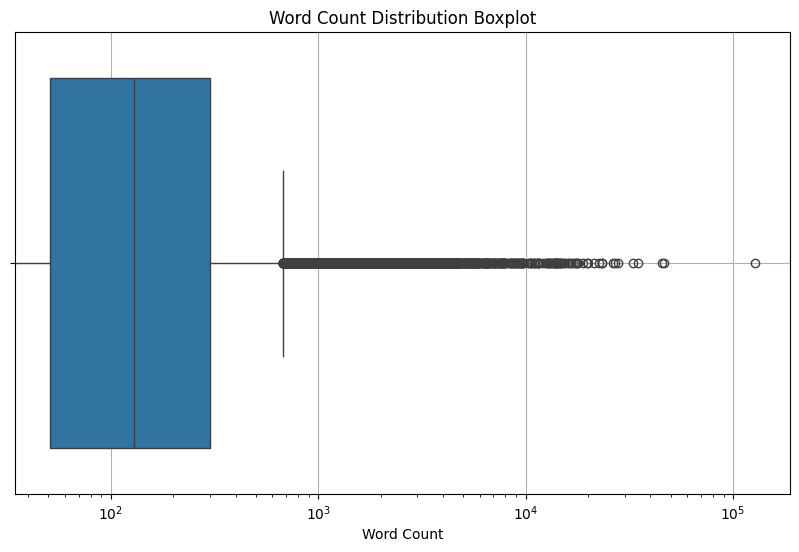

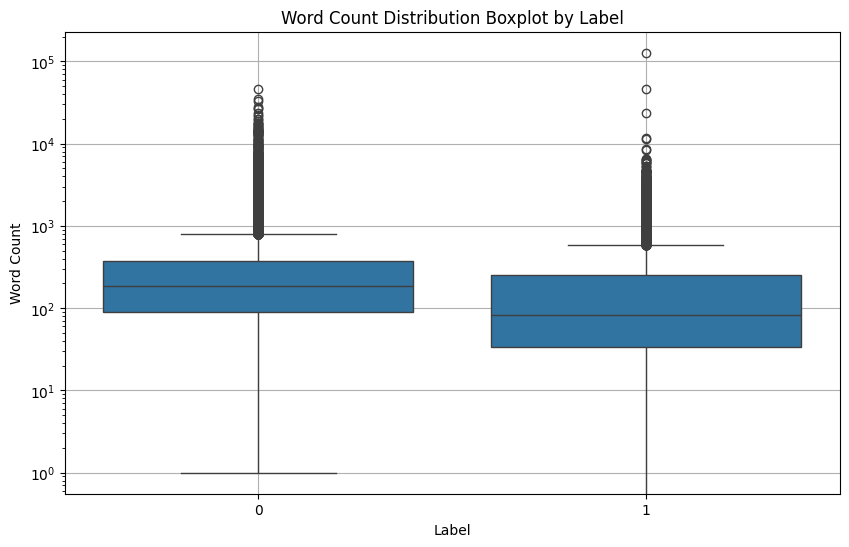

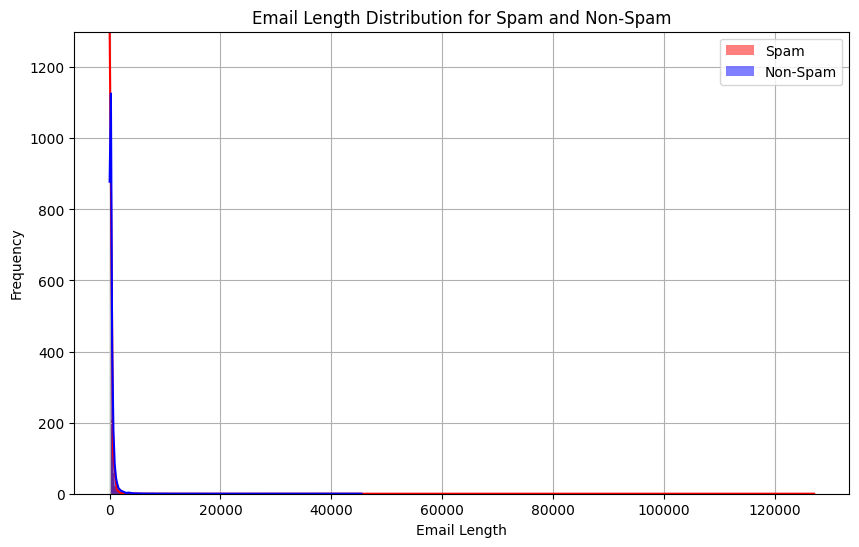

In [ ]:
visualizer.plot_word_count_boxplot()
visualizer.plot_word_count_boxplot_by_label()
visualizer.plot_email_length_histogram()

### Additional word count plots:
This bar plot shows the average word count for spam and non-spam emails.
* Non-Spam Emails: Have a higher average word count (~175 words)
* Spam Emails: Have a lower average word count (~100 words).
* Insight: Non-spam emails tend to be longer than spam emails on average.

#### Min and Max Word Count by Label
This bar plot shows the minimum and maximum word count for spam and non-spam emails.
* Non-Spam Emails: Minimum word count is 0 words; maximum word count is around 22,000 words.
* Spam Emails: Minimum word count is around 0 words; maximum word count is around 55,000 words.
* Insight: Both spam and non-spam emails can have very low word counts, but spam emails can also have extremely high word counts, indicating some very lengthy spam emails.

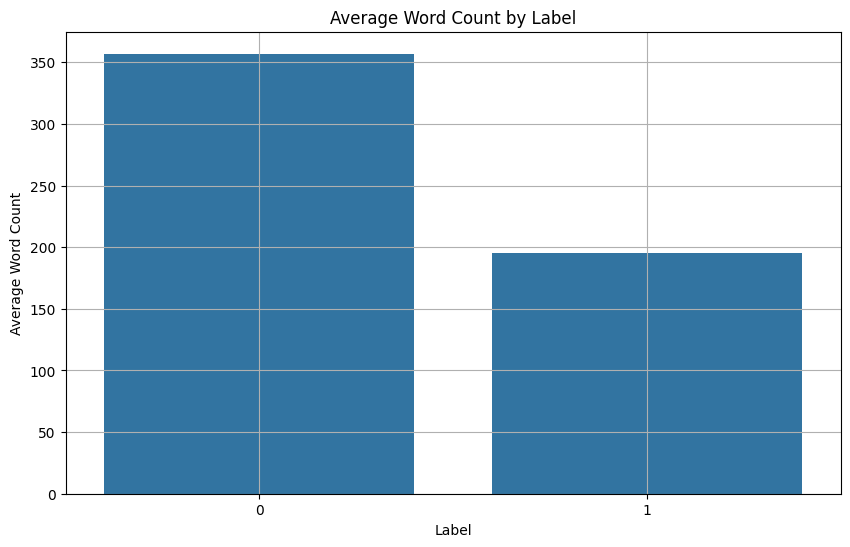

In [ ]:
visualizer.plot_avg_word_count_by_label()

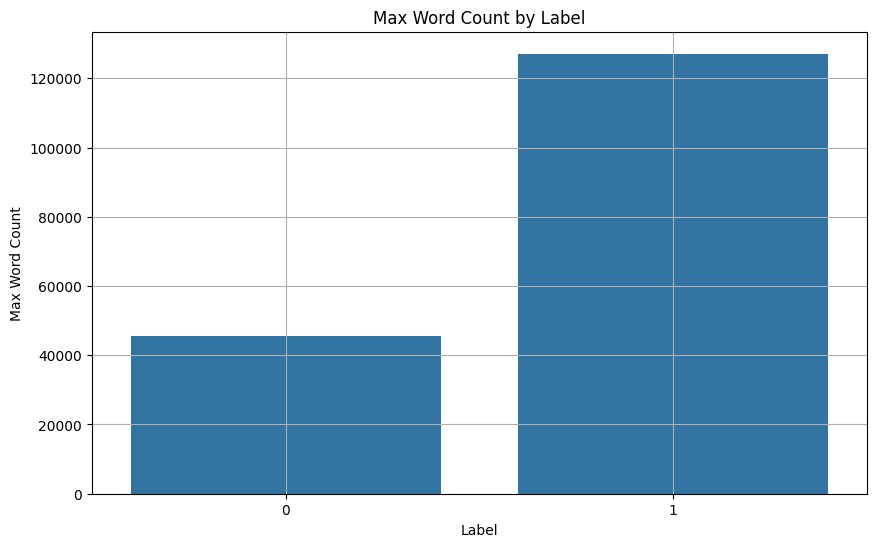

In [ ]:
visualizer.plot_max_word_count_by_label()

### word cloud for the common words analysis
These word clouds show the most frequent words in spam and non-spam emails
* Spam Emails: Common words include "top," "news," "daily," "cable," "network," and "videos."
* Non-Spam Emails: Common words include "added," "sender," "submission," "note," "virus," and "total."
* Insight: Spam emails often use words related to news and media, while non-spam emails include terms related to submissions and system notifications.

Word Cloud for Spam Emails


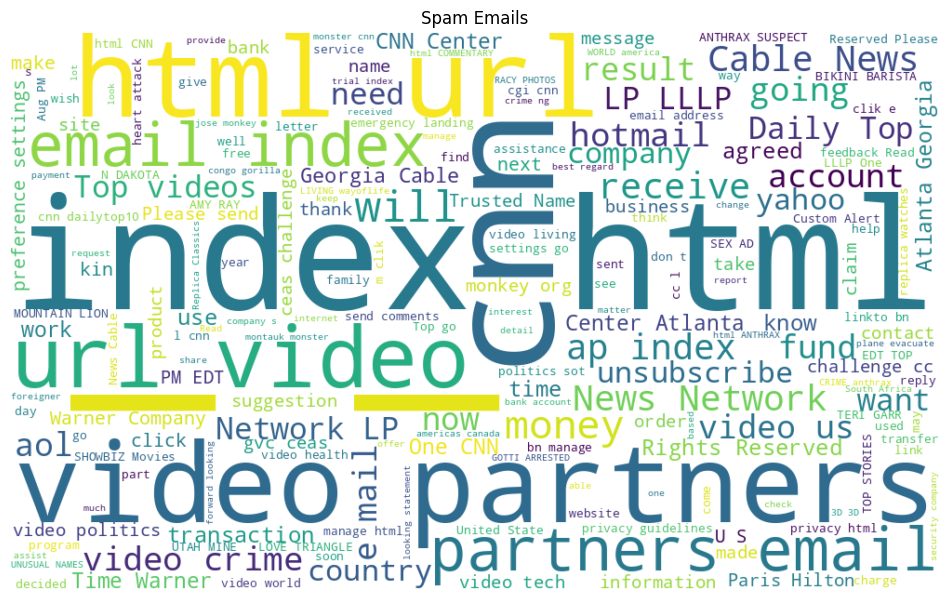

Word Cloud for Non-Spam Emails


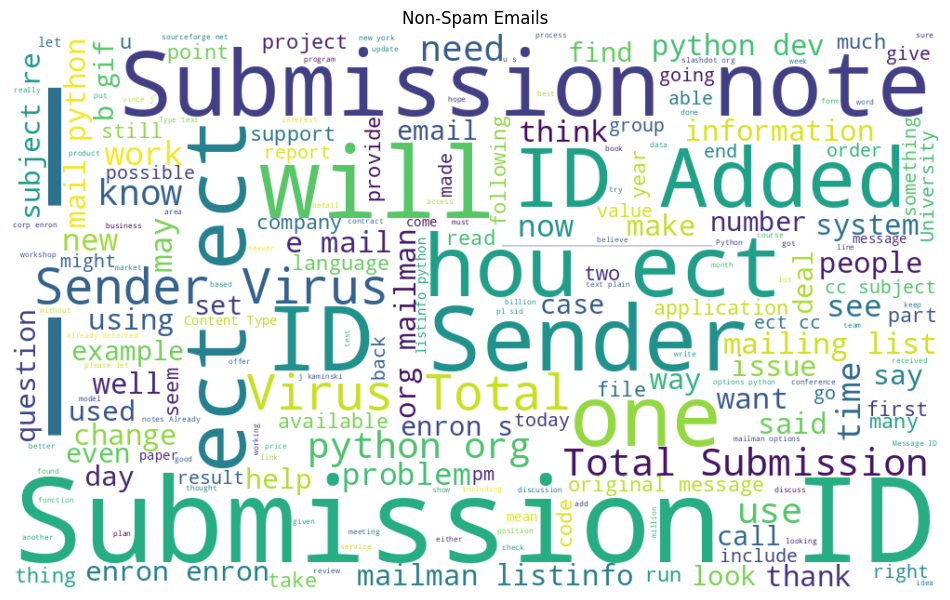

In [ ]:
visualizer.plot_word_clouds()

### Character Count Distribution Boxplot by Label
Explanation: Boxplot showing the distribution of character counts for spam and non-spam emails.

Summary: Both spam and non-spam emails have similar character count distributions, with outliers in both categories

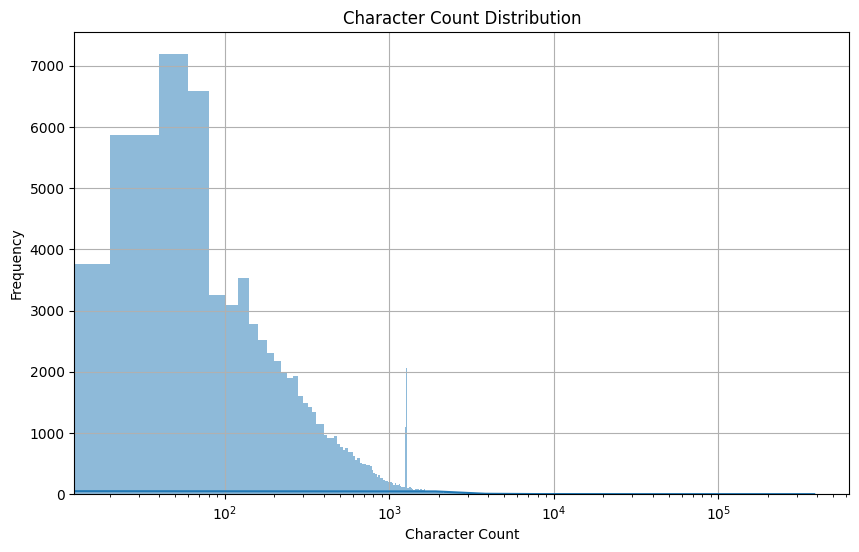

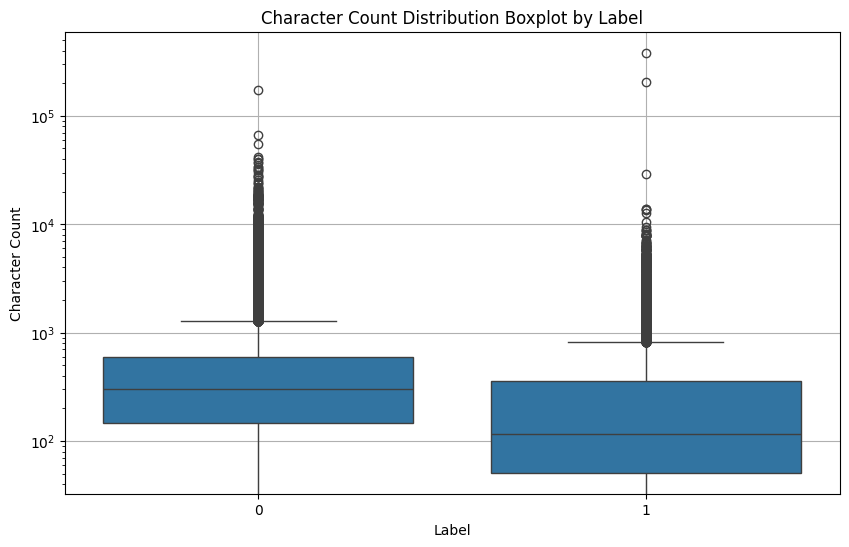

In [ ]:
visualizer.plot_char_count_distribution()
visualizer.plot_char_count_boxplot()

### Capital Letter Ratio Distribution
Explanation: Histogram showing the distribution of capital letter ratios in emails.

Summary: Most emails have a low capital letter ratio, with some emails having a higher proportion of capital letters.

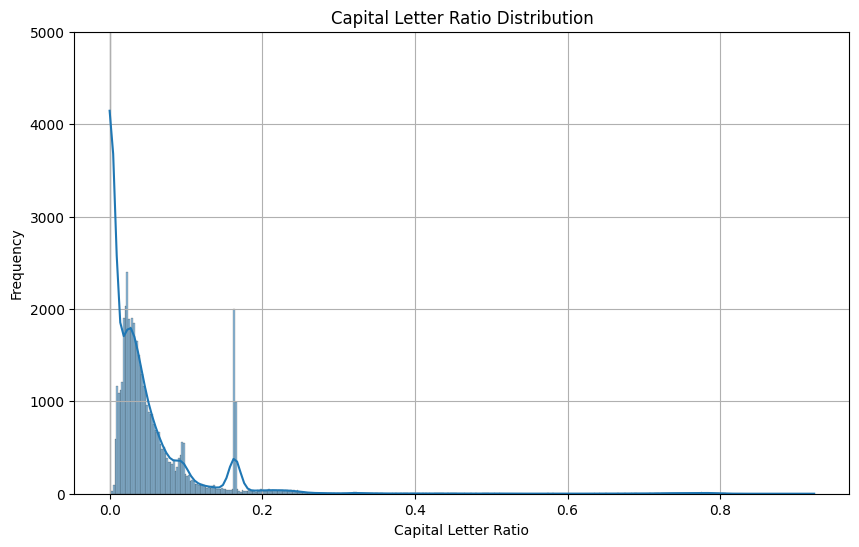

In [ ]:
visualizer.plot_capital_ratio_distribution()

### Sentiment Distribution:
Explanation: This histogram shows the distribution of sentiment polarity scores for the emails, ranging from -1 (very negative) to 1 (very positive). Most emails have a neutral or slightly positive sentiment, with a high peak at zero, indicating a neutral sentiment.

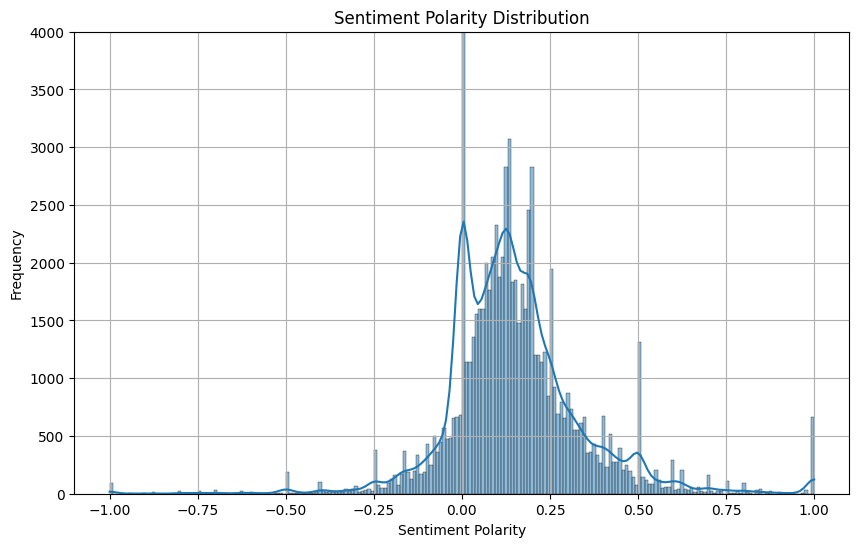

In [ ]:
visualizer.plot_sentiment_distribution()

### Correlation Matrix
Explanation: Heatmap showing correlations between numeric features.

Summary: Strong positive correlations between word_count and char_count, and moderate correlations between char_count and capital_count.

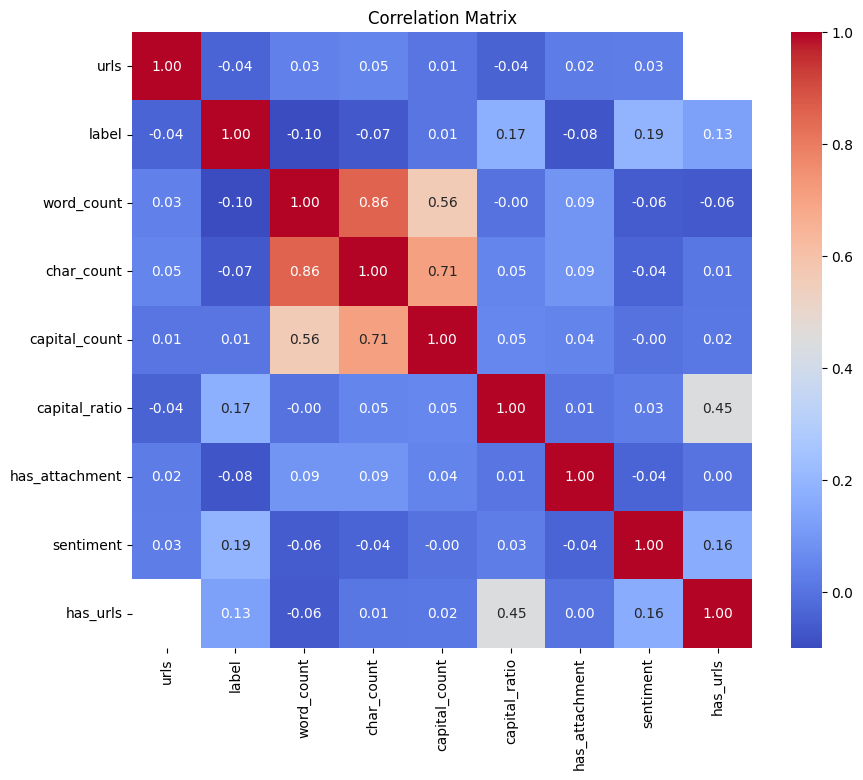

In [ ]:
visualizer.plot_correlation_matrix()

### spam rate by different periods
#### Spam Rate by Hour: This line plot shows the spam rate for each hour of the day
* Peaks in spam rate are observed around 10 AM and between 3 PM and 6 PM
* The lowest spam rate is observed around 11 PM.
#### Spam Rate by Week
* The spam rate remains high and consistent for the initial weeks.
* There is a noticeable drop in spam rate around the 25th week.
* A sharp increase in spam rate is observed after the 40th week, returning to near 100%.
#### Spam Rate by Weekday
* The spam rate varies throughout the week.
* The highest spam rate is observed on Friday and thursday.
* The lowest spam rate is observed on Wednesday.
* The spam rate tends to be higher at the beginning and the end of the week.

In [ ]:
visualizer.raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82486 entries, 0 to 82485
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   sender          49529 non-null  object             
 1   date            47525 non-null  datetime64[ns, UTC]
 2   receiver        47768 non-null  object             
 3   body            82486 non-null  object             
 4   subject         82139 non-null  object             
 5   urls            49860 non-null  float64            
 6   label           82486 non-null  int64              
 7   source          82486 non-null  object             
 8   word_count      82486 non-null  int64              
 9   char_count      82486 non-null  int64              
 10  capital_count   82486 non-null  int64              
 11  capital_ratio   82485 non-null  float64            
 12  domain          82486 non-null  object             
 13  has_attachment  82486 non-null 

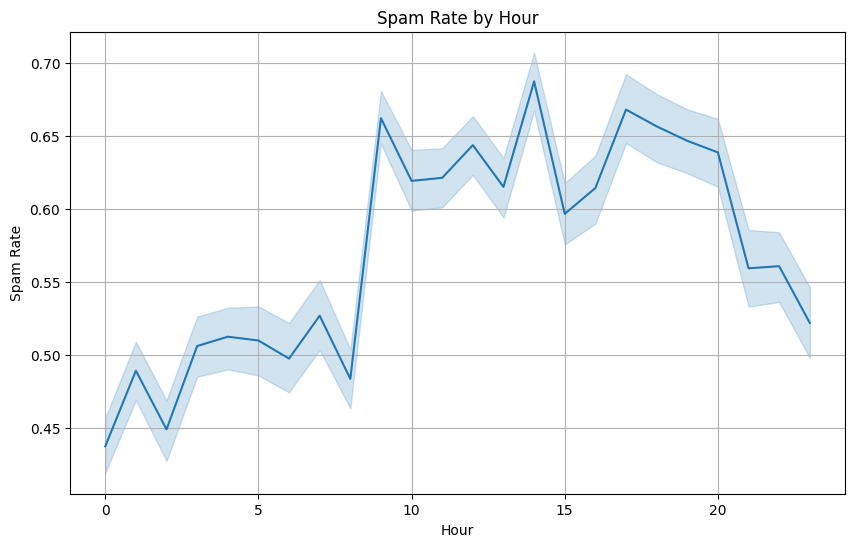

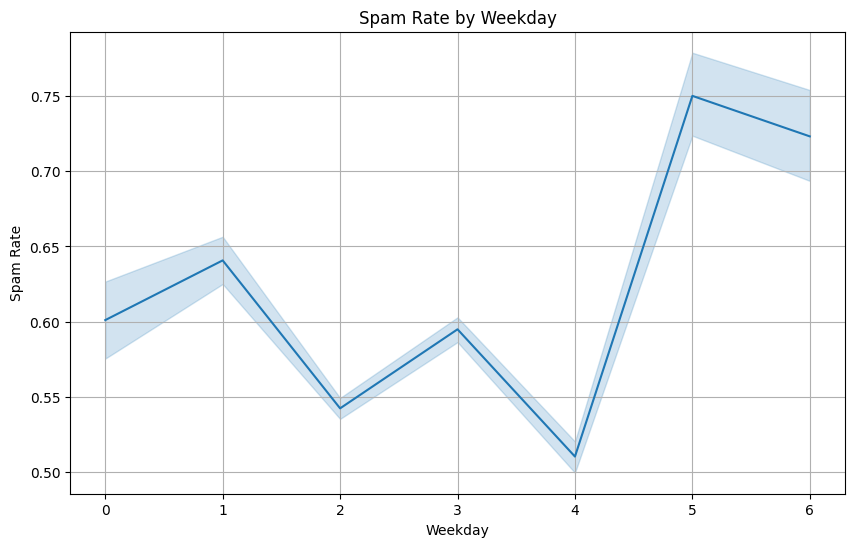

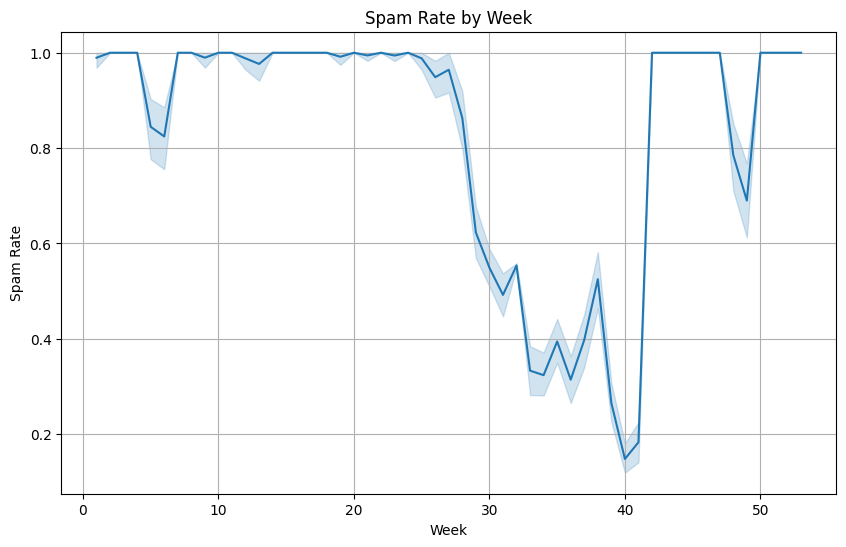

In [ ]:
visualizer.plot_spam_rate_by_time(time_feature='hour')
visualizer.plot_spam_rate_by_time(time_feature='weekday')
visualizer.plot_spam_rate_by_time(time_feature='week')

### URL plots

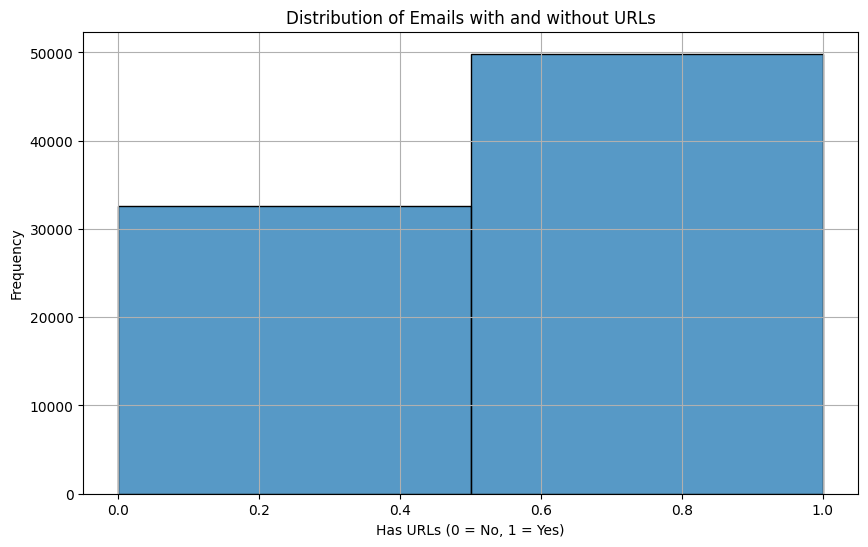

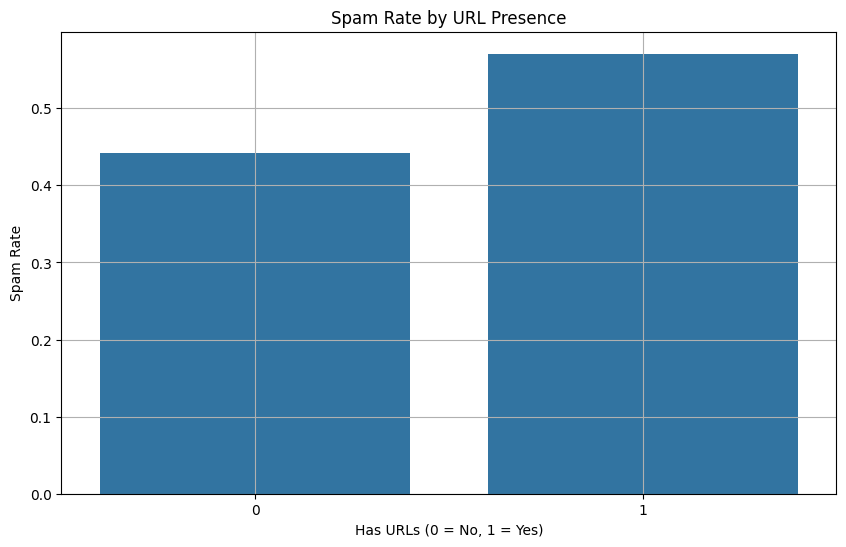

In [ ]:
# Perform visualizations for URL analysis
visualizer.plot_url_distribution()
visualizer.plot_spam_rate_by_url()

In [ ]:
visualizer.raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82486 entries, 0 to 82485
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   sender          49529 non-null  object             
 1   date            47525 non-null  datetime64[ns, UTC]
 2   receiver        47768 non-null  object             
 3   body            82486 non-null  object             
 4   subject         82139 non-null  object             
 5   urls            49860 non-null  float64            
 6   label           82486 non-null  int64              
 7   source          82486 non-null  object             
 8   word_count      82486 non-null  int64              
 9   char_count      82486 non-null  int64              
 10  capital_count   82486 non-null  int64              
 11  capital_ratio   82485 non-null  float64            
 12  domain          82486 non-null  object             
 13  has_attachment  82486 non-null 

### By Distribution of senders

### MetaData visualizations on senders

In [ ]:
# visualizer.plot_spam_rate_by_metadata(column='domain', top_n=10)

### Pickles

In [ ]:
file_path = '/content/drive/My Drive/deep_learning_ex1/final_project_data'
pkl_file_path = '/content/drive/My Drive/deep_learning_ex1/final_project_data/preprocessed_data.pkl'

In [ ]:
# Define the path in Google Drive where you want to save the preprocessed data
analytics.raw_df.to_pickle(pkl_file_path)

# Part B

## 1. Imports

In [1]:
!pip install datasets
!pip install pytorch_lightning
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 4.8 MB

In [2]:
# Standard library imports
print("Script started")
import os
import warnings

# Data manipulation and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Sklearn for classic machine learning and preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

# PyTorch and related utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils.prune as prune
import torch.quantization
from torch.utils.data import DataLoader, Dataset, TensorDataset

# PyTorch Lightning
import pytorch_lightning as pl
import torchmetrics

# Transformers and Datasets for NLP models
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from datasets import Dataset

# TensorFlow and Keras for additional deep learning models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# XGBoost for gradient boosting
import xgboost as xgb

# Working with Google Colab (if applicable)
from google.colab import drive

import pickle

from collections import OrderedDict # Added import statement to the top of the file

print("Imports part is finished")

Script started
Imports part is finished


In [3]:
#### Load Data from Local Files
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/deep_learning_ex1/final_project_data'
pkl_file_path = '/content/drive/My Drive/deep_learning_ex1/final_project_data/preprocessed_data.pkl'
manipulated_wo_body = f'{file_path}/manipulated_wo_body.pkl'
manipulated_only_body = f'{file_path}/manipulated_only_body.pkl'
raw_data = f'{file_path}/raw_data.pkl'

manipulated_wo_body_df = pd.read_pickle(manipulated_wo_body)
manipulated_only_body_df = pd.read_pickle(manipulated_only_body)
raw_data_df = pd.read_pickle(raw_data)

if os.path.exists(pkl_file_path):
    df = pd.read_pickle(pkl_file_path)
    print("Columns available after loading:", df.columns.tolist())
else:
    print("Preprocessed data file not found.")

Mounted at /content/drive
Columns available after loading: ['date', 'body', 'urls', 'subject', 'label', 'sender', 'receiver', 'source', 'word_count', 'char_count', 'capital_count', 'capital_ratio', 'domain', 'has_attachment', 'hour', 'weekday', 'week', 'sentiment', 'has_urls']


In [4]:
#### Save Manipulated DataFrames to Local Files
df[['label', 'body']].to_pickle(manipulated_only_body)
phishing_email_df = pd.read_csv(f'{file_path}/phishing_email.csv')
phishing_email_df.rename(columns={'text_combined': 'body'}, inplace=True)
phishing_email_df.to_pickle(raw_data)

In [5]:
# Display the first few rows of each DataFrame to verify the data
print("No body; ", manipulated_wo_body_df.head())
print("Only Body: ", manipulated_only_body_df.head())
print("Raw" ,raw_data_df.head())


No body;     capital_count  capital_ratio  has_urls  hour  sentiment  week  weekday  \
0              6       0.021978         1  23.0   0.039236  32.0      1.0   
1              1       0.012195         1  23.0   0.000000  32.0      1.0   
2            645       0.164625         1   8.0   0.198214  32.0      2.0   
3            184       0.007535         1  23.0   0.090032  32.0      1.0   
4             36       0.205714         1  23.0   0.000000  32.0      1.0   

   word_count  domain_other_domains  source_Enron  source_Ling  \
0          46                  True         False        False   
1           9                  True         False        False   
2         302                  True         False        False   
3        2660                  True         False        False   
4           2                  True         False        False   

   source_Nazario  source_Nigerian_Fraud  source_SpamAssasin  \
0           False                  False               False   
1 

## 2. Classes

## 2.1 Classes per Task

#### *Project Summary*

In this project, we developed a comprehensive machine learning pipeline aimed at training and optimizing transformer models, specifically XLNet and RoBERTa. Our pipeline integrates several advanced techniques to ensure robust model performance.

- *Data Preparation:* We designed the DataPreprocessing class to handle all aspects of data preparation. This includes tokenizing text data, saving and loading datasets as TensorDataset objects, and creating DataLoaders for training, validation, and testing. This class ensures that our data is efficiently processed and ready for model training.

- *Model Training and Evaluation:* The ModelTrainer class manages the core training process. It supports applying shrinking methods like pruning, quantization, and weight decay, which help in optimizing model performance and size. Additionally, we implemented knowledge distillation within this class to effectively train smaller student models. This class works closely with DataPreprocessing to utilize the prepared DataLoaders.

- *Model Wrapping:* The TransformerModelWrapper class wraps the transformer models, managing their forward passes, training steps, validation, and testing. This class also handles model saving, logging, and memory management, making the training process more efficient and organized. The model wrapper interacts with ModelTrainer to execute these processes.

- *Pipeline Management:* The TrainingPipelineManager class orchestrates the entire workflow, ensuring that each step is executed in the correct sequence. It coordinates data preparation through the DataPreprocessing class, manages training and evaluation via the ModelTrainer class, and handles model operations through the TransformerModelWrapper class. This class is the backbone of the pipeline, ensuring smooth execution and integration of all components.

### *Flow Between Classes:*
The flow begins with the TrainingPipelineManager, which initiates data preparation through DataPreprocessing. Once the data is ready, TrainingPipelineManager calls on ModelTrainer to train and evaluate the models using the DataLoaders. During training, the ModelTrainer interacts with the TransformerModelWrapper to manage model-specific tasks such as forward passes and saving model states. After the main models are trained, TrainingPipelineManager handles the training of student models through knowledge distillation, again utilizing the coordination between ModelTrainer and TransformerModelWrapper.

Overall, our project is designed to be modular, allowing for flexibility in integrating different models and techniques. The clear flow between classes ensures that each component works together seamlessly, resulting in a robust and adaptable pipeline.

#### Data Preprocessing:
Handles data tokenization, saving/loading of tokenized data, and creation of DataLoaders for training and evaluation.

In [85]:
class DataPreprocessing:
    def __init__(self, data, tokenizer_name_xlnet, tokenizer_name_roberta, test_size=0.4, max_length=128, truncate_length=1000):
        """
        Initialize the DataPreprocessing class with the dataset, tokenizer names, and configuration parameters.
        """
        self.data = data
        self.tokenizers = {
            'xlnet-base-cased': AutoTokenizer.from_pretrained(tokenizer_name_xlnet),
            'roberta-base': AutoTokenizer.from_pretrained(tokenizer_name_roberta)
        }
        self.test_size = test_size
        self.max_length = max_length
        self.truncate_length = truncate_length

        print("DataPreprocessing initialized with:")
        print(f"Test size: {self.test_size}, Max length: {self.max_length}, Truncate length: {self.truncate_length}")

    def find_long_texts(self):
        """
        Identify texts in the dataset that exceed the specified truncate length.
        """
        long_texts = [text for text in self.data['body'] if len(text) > self.truncate_length]
        print(f"Found {len(long_texts)} long texts that exceed {self.truncate_length} characters.")
        return long_texts

    def split_data(self):
        """
        Split the data into training and validation sets.
        """
        train_data, val_data = train_test_split(self.data, test_size=self.test_size, random_state=42)
        print(f"Data split into {len(train_data)} training samples and {len(val_data)} validation samples.")
        return train_data, val_data

    def tokenize_data(self, data, model_name, batch_size=32, save_path=None):
        """
        Tokenize the data using the specified tokenizer and create a TensorDataset.
        Optionally save the tokenized data to a .pkl file.
        """
        tokenizer = self.tokenizers[model_name]
        encodings = tokenizer(
            data['body'].tolist(),
            truncation=True, # Truncating if too long
            padding=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        dataset = TensorDataset(
            encodings['input_ids'], encodings['attention_mask'], torch.tensor(data['label'].values)
        )

        print(f"Dataset type before saving: {type(dataset)}")

        # Save the TensorDataset directly
        if save_path:
            with open(save_path, 'wb') as f:
                pickle.dump(dataset, f)
            print(f"Tokenized data saved to {save_path}")

        return dataset  # Return the TensorDataset, (instead ofh DataLoader)

    def load_tokenized_data(self, load_path):
        """
        Load tokenized data from a .pkl file.
        """
        with open(load_path, 'rb') as f:
            dataset = pickle.load(f)
        print(f"Loaded data type: {type(dataset)}, length: {len(dataset)}")
        return dataset

    def prepare_data(self, model_name):
        """
        Prepare the data by splitting, tokenizing, and creating DataLoaders.
        If the tokenized data .pkl file exists, load it. Otherwise, run the tokenizers and save the data.
        """
        tokenized_data_path = f'{file_path}/{model_name}_tokenized_data.pkl'

        if os.path.exists(tokenized_data_path):
            print(f"Loading tokenized data from {tokenized_data_path}...")
            dataset = self.load_tokenized_data(tokenized_data_path)
            print(f"Loaded dataset type: {type(dataset)}, length: {len(dataset)}")

            # Ensure the dataset is not a DataLoader
            if isinstance(dataset, DataLoader):
                raise ValueError(f"Expected TensorDataset but got DataLoader in {tokenized_data_path}")

            # Split the loaded TensorDataset into train, validation, and test sets
            train_size = int((1-self.test_size) * len(dataset)) # modify to generic
            val_size = int((self.test_size/2) * len(dataset))
            test_size = len(dataset) - train_size - val_size

            train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
                dataset, [train_size, val_size, test_size])

            train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
            test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

            return train_loader, val_loader, test_loader

        else:
            print("Tokenized data file not found. Running tokenization...")
            dataset = self.tokenize_data(self.data, model_name, save_path=tokenized_data_path)
            print(f"Dataset type after tokenization: {type(dataset)}")

            train_size = int((1-self.test_size) * len(dataset))
            val_size = int((self.test_size/2) * len(dataset))
            test_size = len(dataset) - train_size - val_size

            train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
                dataset, [train_size, val_size, test_size])

            train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
            test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

            return train_loader, val_loader, test_loader


#### Class: ModelTrainer
Manages model training, evaluation, and application of shrinking methods, including knowledge distillation.

In [91]:
class ModelTrainer:
    def __init__(self, model, train_loader, weight_decay=1e-5):
        """
        Initialize the ModelTrainer with the model, DataLoaders, and the desired pruning method.
        """
        self.model = model
        self.train_loader = train_loader
        self.weight_decay = weight_decay
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=2e-5, weight_decay=self.weight_decay) # updated code calls the model attribute of the ModelWrapper object

    def train_model(self, epochs=5):
        """
        Train the model for a specified number of epochs.
        """
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(device)
        for epoch in range(epochs):
            self.model.train() # training mode
            epoch_loss = 0
            for batch_idx, batch in enumerate(self.train_loader):
                result = self.model.training_step(batch, batch_idx)
                loss = result['loss']
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
                if batch_idx % 10 == 0:
                  print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}, Avg Batch Loss: {epoch_loss / batch_idx if batch_idx > 0 else 0.0 :.4f}, Device: {device}")
        self.model.on_train_end()

    def evaluate_model(self, loader):
        """
        Evaluate the model on a specified DataLoader.
        """
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("running on CUDA" if torch.cuda.is_available() else "running on CPU")
        self.model.to(device)
        self.model.eval()
        results = []
        print("Evaluating model...")
        with torch.no_grad():
            for batch_idx, batch in enumerate(loader):
                results.append(self.model.validation_step(batch, batch_idx))
                if batch_idx % 200 == 0:  # Print every 200th batch
                    print(f"Batch {batch_idx} evaluated: {results}")

            metrics = self.model.validation_epoch_end(results)
            print(f"Evaluation complete. Metrics: {metrics}")
        return metrics

    def evaluate_quantized_model(self, loader):
        """
        Evaluate a quantized model on a specified DataLoader using CPU.
        """
        device = torch.device("cpu")
        print("running on CPU for quantized model")

        self.model.to(device)
        self.model.eval()
        results = []
        print("Evaluating quantized model...")
        with torch.no_grad():
            for batch_idx, batch in enumerate(loader):
                batch = [item.to(device) for item in batch]  # Ensure batch is on CPU
                results.append(self.model.validation_step(batch, batch_idx))
                if batch_idx % 200 == 0:  # Print every 200th batch
                    print(f"Batch {batch_idx} evaluated: {results}")

            metrics = self.model.validation_epoch_end(results)
            print(f"Evaluation complete. Metrics: {metrics}")
        return metrics

### for shrinking ###
    @staticmethod
    def distillation_loss(student_outputs, teacher_outputs, labels, temperature=2.0, alpha=0.5):
      """
      Compute the distillation loss between the student and teacher model outputs.
      """
      # Task loss (cross-entropy with ground truth labels)
      task_loss = nn.CrossEntropyLoss()(student_outputs, labels)
      teacher_logits = teacher_outputs.logits

      # Distillation loss (soft cross-entropy between teacher and student outputs)
      distillation_loss = nn.KLDivLoss(reduction='batchmean')(
          nn.functional.log_softmax(student_outputs / temperature, dim=1),
          nn.functional.softmax(teacher_logits / temperature, dim=1)
      ) * (temperature ** 2)

      # Combine the two losses with weighting
      total_loss = alpha * task_loss + (1 - alpha) * distillation_loss
      return total_loss

    def train_student(self, teacher_model, student_model, train_loader, epochs=5, temperature=2.0, alpha=0.5):
      """
      Train the student model using knowledge distillation from the teacher model.
      """

      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      student_model = student_model.to(device)
      teacher_model = teacher_model.to(device)
      optimizer = optim.Adam(student_model.parameters(), lr=1e-4)

      student_model.train()
      teacher_model.eval()  # Teacher is not trained, just provides predictions

      for epoch in range(epochs):
          total_loss = 0
          for batch_idx, batch in enumerate(train_loader):

              inputs = batch[0].to(device)
              attention_mask = batch[1].to(device)
              labels = batch[2].to(device)

              # Forward pass through both teacher and student
              with torch.no_grad():
                  teacher_outputs = teacher_model(inputs)
              student_outputs = student_model(inputs)

              # Calculate the distillation loss
              loss = self.distillation_loss(student_outputs, teacher_outputs, labels, temperature, alpha)

              # Backpropagation and optimization
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

              total_loss += loss.item()

          avg_loss = total_loss / len(train_loader)
          print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

      print("Student model training complete!")

      return student_model


    def evaluate_student(self, model, dataloader):
      """
      Evaluate the student model on a given DataLoader.
      """
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      model.to(device)
      model.eval()
      correct = 0
      total = 0
      with torch.no_grad():
          # for inputs, labels in dataloader:
            for batch_idx, batch in enumerate(dataloader):

              inputs = batch[0].to(device)
              attention_mask = batch[1].to(device)
              labels = batch[2].to(device)

              # inputs, labels = inputs.to(device), labels.to(device)
              outputs = model(inputs)
              _, predicted = torch.max(outputs, dim=1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

      accuracy = 100 * correct / total
      print(f"Model Accuracy: {accuracy:.2f}%")
      return accuracy

    def prune_model(self, amount = 0.2):
      for name, module in self.model.named_modules():
          if isinstance(module, nn.Linear):
              # Ensure the weight tensor is contiguous
              module.weight.data = module.weight.data.contiguous()
              prune.l1_unstructured(module, name='weight', amount=amount)
              print(f"Sparsity in {name}.weight: {100. * float(torch.sum(module.weight == 0)) / float(module.weight.nelement()):.2f}%")
      self.model.to("cuda" if torch.cuda.is_available() else "cpu")
      return self.model

#### Class: TransformerModelWrapper
Wraps transformer models, managing forward passes, training steps, validation, and testing.

In [92]:
class TransformerModelWrapper(pl.LightningModule):
    def __init__(self, model_name, num_labels=2, custom_model=None):
        """
        Initialize the TransformerModelWrapper with a pre-trained model or a custom model.
        """
        self.model_name = model_name
        super(TransformerModelWrapper, self).__init__()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if custom_model:
            self.model = custom_model
        else:
            print("model run in CUDA. i.e GPU.")
            self.model = AutoModelForSequenceClassification.from_pretrained(
                model_name, num_labels=num_labels).to(device)
        self.dropout = nn.Dropout(0.3).to(device)
        self.roc_auc_metric = torchmetrics.AUROC(task='binary', num_classes=num_labels)

        print(f"Initialized TransformerModelWrapper with model: {model_name}")
        print(f"Using device: {device}")

    def forward(self, input_ids, attention_mask, labels=None):
        """
        Forward pass for the model.
        """
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = self.dropout(outputs.logits)

        if labels is not None:
            loss = F.cross_entropy(logits, labels)
            return loss, logits
        else:
            return logits

    def step(self, batch, batch_idx, stage):
        """
        Perform a step during training, validation, or testing.
        """
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        loss, logits = self(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        # Calculate metrics
        preds = torch.argmax(logits, dim=1)
        roc_auc = self.roc_auc_metric(preds, labels)
        f1 = f1_score(labels.cpu(), preds.cpu(), average='weighted')
        accuracy = accuracy_score(labels.cpu(), preds.cpu())

        return {'loss': loss, 'roc_auc': roc_auc, 'f1': f1, 'accuracy': accuracy, 'preds': preds, 'labels': labels}

    def training_step(self, batch, batch_idx):
        """
        Perform a single training step.
        """
        return self.step(batch, batch_idx, 'train')

    def validation_step(self, batch, batch_idx):
        """
        Perform a single validation step.
        """
        return self.step(batch, batch_idx, 'val')

    def validation_epoch_end(self, outputs):
        """
        Aggregate validation results at the end of the epoch.
        """
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        avg_roc_auc = torch.stack([x['roc_auc'] for x in outputs]).mean()
        avg_f1 = torch.tensor([x['f1'] for x in outputs]).mean()
        avg_accuracy = torch.tensor([x['accuracy'] for x in outputs]).mean()

        # Manual logging
        print(f"Validation epoch end - Average Loss: {avg_loss:.4f}, Average ROC AUC: {avg_roc_auc:.4f}, Average F1 Score: {avg_f1:.4f}, Average Accuracy: {avg_accuracy:.4f}")  #NEWWW

        # Return metrics as a dictionary
        return {'val_loss': avg_loss, 'val_roc_auc': avg_roc_auc, 'val_f1': avg_f1, 'val_accuracy': avg_accuracy}

    def configure_optimizers(self):
        """
        Configure optimizers for training.
        """
        optimizer = torch.optim.AdamW(self.parameters(), lr=2e-5)
        return optimizer

    def on_train_end(self):
        """
        Actions to perform at the end of training, such as saving the model, logging metrics, and clearing CUDA cache.
        """
        # Save the model
        model_path = f"{file_path}/{self.model_name}_model_final.pth"
        torch.save(self.model.state_dict(), model_path)
        print(f"Model state saved as {model_path}")

        # Clear CUDA cache to free up memory
        torch.cuda.empty_cache()
        print("CUDA cache cleared.")
        print("Training complete.")

        gc.collect()
        print("clear unneccarry cache cleared.")

    def on_validation_end(self):
        """
        Actions to perform at the end of validation, such as logging final validation metrics and clearing CUDA cache.
        """
        print("Validation complete.")
        val_metrics = self.trainer.callback_metrics
        print(f"Final Validation Metrics: Loss: {val_metrics['val_loss']:.4f}, ROC AUC: {val_metrics['val_roc_auc']:.4f}")

        # Clear CUDA cache to free up memory
        torch.cuda.empty_cache()
        print("CUDA cache cleared.")


#### Class: StudentModel
Implement the student-teacher shrinking method

In [ ]:
class StudentModel(nn.Module):
    def __init__(self, input_dim, num_labels):
        """
        Initialize the StudentModel with a simple architecture.
        """
        super(StudentModel, self).__init__()
        self.fc1 = nn.Linear(128, 50)  # First fully connected layer
        self.fc2 = nn.Linear(50, num_labels)  # Output layer
        self.dropout = nn.Dropout(0.3)  # Add dropout for regularization

        print(f"Initialized StudentModel with input dimension {input_dim} and output classes {num_labels}")

    def forward(self, input_ids, attention_mask=None):
        """
        Forward pass for the student model.
        """
        x = torch.relu(self.fc1(input_ids.float()))
        x = self.dropout(x)
        logits = self.fc2(x)
        return logits

#### Class: TrainingPipelineManager
Orchestrates the entire training pipeline, including data preparation, model training, evaluation, and student model training.

In [99]:
class TrainingPipelineManager:
    def __init__(self, data, model_name_xlnet, model_name_roberta):
        """
        Initialize the TrainingPipelineManager with the dataset and model names.
        """
        self.data = data
        self.data_manager = DataPreprocessing(data, model_name_xlnet, model_name_roberta)
        self.train_loader_xlnet, self.val_loader_xlnet, self.test_loader_xlnet = self.data_manager.prepare_data(model_name_xlnet)
        self.train_loader_roberta, self.val_loader_roberta, self.test_loader_roberta = self.data_manager.prepare_data(model_name_roberta)
        self.metrics_df_val = pd.DataFrame()
        self.metrics_df_test = pd.DataFrame()

        print(f"TrainingPipelineManager initialized with XLNet and RoBERTa models.")

    def train_model_set_up(self, model_name, train_loader):

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Initialize model and trainer
        model_wrapper = TransformerModelWrapper(model_name=model_name)
        trainer = ModelTrainer(model=model_wrapper, train_loader=train_loader)

        # Train the model
        trainer.train_model()

        return trainer

    def evaluate_model_set_up(self, model_name, model_wrapper, loader,mode = 'val'):
        """
        Internal method to train and evaluate a model with pruning and weight decay.
        """
        # Detect if the model is quantized
        is_quantized = any('Quantized' in str(type(layer)) for layer in model_wrapper.modules())
        print(f"Is the model quantized? {'Yes' if is_quantized else 'No'}")

        # Initialize the ModelTrainer
        trainer = ModelTrainer(model=model_wrapper, train_loader=None)  # No training loader needed for evaluation
        print("Trainer is ready")

        # Check if model is quantized and force it to run on CPU
        if is_quantized:
            print("Forcing CPU usage for evaluation of quantized model.")
            model_wrapper.to('cpu')
        else:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model_wrapper.to(device)
            print(f"Running evaluation on {device}")

        # Evaluate using the correct method
        if is_quantized:
            metrics = trainer.evaluate_quantized_model(loader)
        else:
            metrics = trainer.evaluate_model(loader)

        # Log the metrics and return
        return self.log_metrics(model_name, 'default', metrics, mode)


    def apply_post_training_shrinking(self, model_name, method, trained_model):
        """
        Apply the specified post-training shrinking method to the trained model.
        """

        if trained_model is None:
            raise ValueError(f"No trained model found for {model_name}.")

        model_wrapper = TransformerModelWrapper(model_name=None, custom_model=trained_model)
        trainer = ModelTrainer(model=model_wrapper, train_loader=None)

        if method == 'quantize':
            print('method = quantize')
            quantized_model = torch.quantization.quantize_dynamic(trained_model,
                                                                  {torch.nn.Linear},
                                                                  dtype=torch.qint8   # Quantize to 8-bit integers
                                                                  )
            model_wrapper = TransformerModelWrapper(model_name=None, custom_model=quantized_model)
            trainer = ModelTrainer(model=model_wrapper, train_loader=None)
            return trainer.model

        elif method == 'distillation':
            print('method = distillation')
            # Train student model with distillation
            student_model = StudentModel(input_dim=trained_model.model.config.hidden_size, num_labels=2)
            trained_student = trainer.train_student(trained_model.model, student_model, self.train_loader_xlnet if 'xlnet' in model_name else self.train_loader_roberta)
            results_distillation = trainer.evaluate_student(student_model, self.test_loader_xlnet if 'xlnet' in model_name else self.test_loader_roberta)
            return results_distillation

        elif method == 'prune' :
            print('Applying pruning...')
            pruned_model = trainer.prune_model(amount=0.2)

        else:
            raise ValueError(f"Unknown method: {method}")

        return trainer.model

    def log_metrics(self, model_name, method, metrics, mode = 'val'):
        """
        Log metrics for a specific model and shrinking method.
        """
        metrics_entry = {
            'model': model_name,
            'method': method,
            'val_loss': metrics['val_loss'].item(),
            'val_roc_auc': metrics['val_roc_auc'].item(),
            'f1_score': metrics['val_f1'].item(),
            'accuracy': metrics['val_accuracy'].item()
        }
        if mode == 'val':
          self.metrics_df_val = pd.concat([self.metrics_df_val, pd.DataFrame([metrics_entry])], ignore_index=True)
          return self.metrics_df_val
        else:
          self.metrics_df_test = pd.concat([self.metrics_df_test, pd.DataFrame([metrics_entry])], ignore_index=True)
          return self.metrics_df_test

    def get_predictions(self, model_name, test_loader):
        """
        Get predictions from a specified model using the test data loader.
        """
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if model_name not in self.trained_models:
            raise ValueError(f"No trained model found for {model_name}.")

        model = self.trained_models[model_name]
        model.eval()  # Set the model to evaluation mode

        predictions = []
        with torch.no_grad():
            for inputs, _ in test_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                predictions.extend(outputs.cpu().numpy())

        return np.array(predictions)

    @staticmethod
    def load_model_from_drive(full_path, model_class, model_name, device='cpu'):
        """
        Load a model from storage, adjusting for potential key mismatches in the state dictionary,
        specifically handling models that have undergone pruning or similar transformations.
        """
        # Load the model state dict from the .pth file with security consideration
        state_dict = torch.load(full_path, map_location=torch.device(device), weights_only=True)

        # Create a new state dictionary with the expected keys
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            new_k = k.replace('_orig', '') if '_orig' in k else k  # Adjust keys
            if '_mask' not in k:  # Ignore mask keys if present
                new_state_dict[new_k] = v

        # Initialize the model with the appropriate configuration
        model = model_class(model_name=model_name)
        # Load the adjusted state dictionary into the model
        try:
            model.load_state_dict(new_state_dict, strict=False)
        except RuntimeError as e:
            print("RuntimeError in loading state dict: ", e)
            # For debugging, print which keys are missing or unexpected
            model_keys = set(model.state_dict().keys())
            loaded_keys = set(new_state_dict.keys())
            print("Missing keys in loaded dict:", model_keys - loaded_keys)
            print("Unexpected keys in loaded dict:", loaded_keys - model_keys)

        # Move the model to the appropriate device
        model.to(device)

        return model


## 3. Running project

### create pipeline orchestration

In [100]:
# Step 1: Initialize the pipeline with manipulated text data
project_manipulated = TrainingPipelineManager(
    data=manipulated_only_body_df,
    model_name_xlnet='xlnet-base-cased',
    model_name_roberta='roberta-base'
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


DataPreprocessing initialized with:
Test size: 0.4, Max length: 128, Truncate length: 1000
Loading tokenized data from /content/drive/My Drive/deep_learning_ex1/final_project_data/xlnet-base-cased_tokenized_data.pkl...


/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Loaded data type: <class 'torch.utils.data.dataset.TensorDataset'>, length: 82486
Loaded dataset type: <class 'torch.utils.data.dataset.TensorDataset'>, length: 82486
Loading tokenized data from /content/drive/My Drive/deep_learning_ex1/final_project_data/roberta-base_tokenized_data.pkl...
Loaded data type: <class 'torch.utils.data.dataset.TensorDataset'>, length: 82486
Loaded dataset type: <class 'torch.utils.data.dataset.TensorDataset'>, length: 82486
TrainingPipelineManager initialized with XLNet and RoBERTa models.


### Finetune Xlnet model (for first finetune)

In [12]:
# train xlnet
trained_xlnet = project_manipulated.train_model_set_up('xlnet-base-cased', project_manipulated.train_loader_xlnet)

model run in CUDA. i.e GPU.


pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized TransformerModelWrapper with model: xlnet-base-cased
Using device: cuda
Epoch 1/5, Batch 0, Avg Batch Loss: 0.0000, Device: cuda
Epoch 1/5, Batch 10, Avg Batch Loss: 0.7813, Device: cuda
Epoch 1/5, Batch 20, Avg Batch Loss: 0.7113, Device: cuda
Epoch 1/5, Batch 30, Avg Batch Loss: 0.6698, Device: cuda
Epoch 1/5, Batch 40, Avg Batch Loss: 0.6359, Device: cuda
Epoch 1/5, Batch 50, Avg Batch Loss: 0.6245, Device: cuda
Epoch 1/5, Batch 60, Avg Batch Loss: 0.6143, Device: cuda
Epoch 1/5, Batch 70, Avg Batch Loss: 0.5792, Device: cuda
Epoch 1/5, Batch 80, Avg Batch Loss: 0.5636, Device: cuda
Epoch 1/5, Batch 90, Avg Batch Loss: 0.5287, Device: cuda
Epoch 1/5, Batch 100, Avg Batch Loss: 0.5121, Device: cuda
Epoch 1/5, Batch 110, Avg Batch Loss: 0.4849, Device: cuda
Epoch 1/5, Batch 120, Avg Batch Loss: 0.4661, Device: cuda
Epoch 1/5, Batch 130, Avg Batch Loss: 0.4542, Device: cuda
Epoch 1/5, Batch 140, Avg Batch Loss: 0.4386, Device: cuda
Epoch 1/5, Batch 150, Avg Batch Loss: 0.42

In [13]:
# create a metrics for the evaluation on validation data
xlnet_metrics_val = project_manipulated.evaluate_model_set_up(
    model_name='xlnet-base-cased',
    model_wrapper=trained_xlnet.model, #.model
    loader=project_manipulated.val_loader_xlnet,
    mode='val'
)

trainer is ready
running on CUDA
Evaluating model...
Batch 0 evaluated: [{'loss': tensor(5.4898e-05, device='cuda:0'), 'roc_auc': tensor(1., device='cuda:0'), 'f1': 1.0, 'accuracy': 1.0, 'preds': tensor([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0], device='cuda:0'), 'labels': tensor([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')}]


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Batch 200 evaluated: [{'loss': tensor(5.4898e-05, device='cuda:0'), 'roc_auc': tensor(1., device='cuda:0'), 'f1': 1.0, 'accuracy': 1.0, 'preds': tensor([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0], device='cuda:0'), 'labels': tensor([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')}, {'loss': tensor(0.1511, device='cuda:0'), 'roc_auc': tensor(0.9375, device='cuda:0'), 'f1': 0.9372549019607843, 'accuracy': 0.9375, 'preds': tensor([1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0], device='cuda:0'), 'labels': tensor([1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')}, {'loss': tensor(0.0196, device='cuda:0'), 'roc_auc': tensor(1., device='cuda:0'), 'f1': 1.0, 'accuracy': 1.0, 'preds': tensor([1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0], device='cuda:0'), 'labels': tensor([1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')}, {'loss': tensor(2.5167e-05, device='cuda:0'), 'roc_auc': tensor(1., device='cuda:0'), 'f1': 1.0, 'accuracy': 1.0

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


In [14]:
# create a metrics for the evaluation on test data
xlnet_metrics_test = project_manipulated.evaluate_model_set_up(
    model_name='xlnet-base-cased',
    model_wrapper=trained_xlnet.model,
    loader=project_manipulated.test_loader_xlnet,
    mode='test'
)

trainer is ready
running on CUDA
Evaluating model...
Batch 0 evaluated: [{'loss': tensor(0.0005, device='cuda:0'), 'roc_auc': tensor(1., device='cuda:0'), 'f1': 1.0, 'accuracy': 1.0, 'preds': tensor([0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1], device='cuda:0'), 'labels': tensor([0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1], device='cuda:0')}]
Batch 200 evaluated: [{'loss': tensor(0.0005, device='cuda:0'), 'roc_auc': tensor(1., device='cuda:0'), 'f1': 1.0, 'accuracy': 1.0, 'preds': tensor([0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1], device='cuda:0'), 'labels': tensor([0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1], device='cuda:0')}, {'loss': tensor(0.0087, device='cuda:0'), 'roc_auc': tensor(1., device='cuda:0'), 'f1': 1.0, 'accuracy': 1.0, 'preds': tensor([0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0], device='cuda:0'), 'labels': tensor([0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')}, {'loss': tensor(2.3305e-05, device='cuda:0'), 'roc_auc': tensor(1

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


In [15]:
# Print Summary results

# evaluate the model on validation data
print(project_manipulated.metrics_df_val)

# ecaluate the model on test data
print(project_manipulated.metrics_df_test)

              model   method  val_loss  val_roc_auc  f1_score  accuracy
0  xlnet-base-cased  default  0.039907      0.98723  0.989431  0.989462
              model   method  val_loss  val_roc_auc  f1_score  accuracy
0  xlnet-base-cased  default  0.040825     0.988547  0.990046  0.990068


### Loading Trained Xlnet Model From Drive (To avoid training multiple times)

In [ ]:
# Loading from Checkpoint and Evaluation

# Path to the saved model checkpoint
checkpoint_path = f'{file_path}/xlnet-base-cased_model_final.pth'

# Load the model from the checkpoint using the load_model_from_drive function
loaded_xlnet_model = TrainingPipelineManager.load_model_from_drive(
    full_path=checkpoint_path,
    model_class=TransformerModelWrapper,
    model_name='xlnet-base-cased',
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

In [ ]:
# create a metrics for the evaluation on validation data
xlnet_metrics_val_loaded = project_manipulated.evaluate_model_set_up(
    model_name='xlnet-base-cased',
    model_wrapper=loaded_xlnet_model,
    loader=project_manipulated.val_loader_xlnet,
    mode='val'
)

In [ ]:
# Evaluate the loaded XLNet model on the test set
xlnet_metrics_test_loaded = project_manipulated.evaluate_model_set_up(
    model_name='xlnet-base-cased',
    model_wrapper=loaded_xlnet_model,
    loader=project_manipulated.test_loader_xlnet,
    mode='test'
)

In [ ]:
# Print validation metrics
print("Validation Metrics:")
print(xlnet_metrics_val_loaded)

# Print test metrics
print("Test Metrics:")
print(xlnet_metrics_test_loaded)

In [ ]:
# Print Summary results

# evaluate the model on validation data
print(project_manipulated.metrics_df_val)

# ecaluate the model on test data
print(project_manipulated.metrics_df_test)

### Shrinking

#### Copying the Model's weight for shrinking

In [101]:
checkpoint_path = f'{file_path}/xlnet-base-cased_model_final.pth'

In [17]:
trained_xlnet_for_prune = TrainingPipelineManager.load_model_from_drive(
    full_path=checkpoint_path,
    model_class=TransformerModelWrapper,
    model_name='xlnet-base-cased',
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

model run in CUDA. i.e GPU.


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized TransformerModelWrapper with model: xlnet-base-cased
Using device: cuda


In [47]:
trained_xlnet_for_distil = TrainingPipelineManager.load_model_from_drive(
    full_path=checkpoint_path,
    model_class=TransformerModelWrapper,
    model_name='xlnet-base-cased',
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

model run in CUDA. i.e GPU.


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized TransformerModelWrapper with model: xlnet-base-cased
Using device: cuda


In [19]:
trained_xlnet_for_quntize = TrainingPipelineManager.load_model_from_drive(
    full_path=checkpoint_path,
    model_class=TransformerModelWrapper,
    model_name='xlnet-base-cased',
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

model run in CUDA. i.e GPU.


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized TransformerModelWrapper with model: xlnet-base-cased
Using device: cuda


#### Execute Shrinkinkg

##### Pruning

In [20]:
# create pruned model
pruned_model = project_manipulated.apply_post_training_shrinking('xlnet-base-cased', 'prune', trained_xlnet_for_prune.model)

Initialized TransformerModelWrapper with model: None
Using device: cuda
method = prune
Applying pruning...
Sparsity in model.transformer.layer.0.ff.layer_1.weight: 20.00%
Sparsity in model.transformer.layer.0.ff.layer_2.weight: 20.00%
Sparsity in model.transformer.layer.1.ff.layer_1.weight: 20.00%
Sparsity in model.transformer.layer.1.ff.layer_2.weight: 20.00%
Sparsity in model.transformer.layer.2.ff.layer_1.weight: 20.00%
Sparsity in model.transformer.layer.2.ff.layer_2.weight: 20.00%
Sparsity in model.transformer.layer.3.ff.layer_1.weight: 20.00%
Sparsity in model.transformer.layer.3.ff.layer_2.weight: 20.00%
Sparsity in model.transformer.layer.4.ff.layer_1.weight: 20.00%
Sparsity in model.transformer.layer.4.ff.layer_2.weight: 20.00%
Sparsity in model.transformer.layer.5.ff.layer_1.weight: 20.00%
Sparsity in model.transformer.layer.5.ff.layer_2.weight: 20.00%
Sparsity in model.transformer.layer.6.ff.layer_1.weight: 20.00%
Sparsity in model.transformer.layer.6.ff.layer_2.weight: 20.0

In [21]:
# evaluate pruned model
pruned_metrics = project_manipulated.evaluate_model_set_up('xlnet-base-cased', pruned_model, project_manipulated.val_loader_xlnet)

trainer is ready
running on CUDA
Evaluating model...
Batch 0 evaluated: [{'loss': tensor(0.6794, device='cuda:0'), 'roc_auc': tensor(0.5873, device='cuda:0'), 'f1': 0.5840909090909092, 'accuracy': 0.625, 'preds': tensor([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'), 'labels': tensor([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')}]


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Batch 200 evaluated: [{'loss': tensor(0.6794, device='cuda:0'), 'roc_auc': tensor(0.5873, device='cuda:0'), 'f1': 0.5840909090909092, 'accuracy': 0.625, 'preds': tensor([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'), 'labels': tensor([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')}, {'loss': tensor(0.7105, device='cuda:0'), 'roc_auc': tensor(0.5625, device='cuda:0'), 'f1': 0.5465587044534412, 'accuracy': 0.5625, 'preds': tensor([0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0'), 'labels': tensor([1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')}, {'loss': tensor(0.7314, device='cuda:0'), 'roc_auc': tensor(0.5625, device='cuda:0'), 'f1': 0.5607843137254902, 'accuracy': 0.5625, 'preds': tensor([1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0], device='cuda:0'), 'labels': tensor([1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')}, {'loss': tensor(0.6994, device='cuda:0'), 'roc_auc': tensor(0.7222, devic

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


In [22]:
# models results after pruning
print(pruned_metrics)

              model   method  val_loss  val_roc_auc  f1_score  accuracy
0  xlnet-base-cased  default  0.039907     0.987230  0.989431  0.989462
1  xlnet-base-cased  default  0.703869     0.502981  0.481331  0.495821


##### Distillation

In [48]:
# create distilled model
distilled_metric = project_manipulated.apply_post_training_shrinking('xlnet-base-cased', 'distillation', trained_xlnet_for_distil)

Initialized TransformerModelWrapper with model: None
Using device: cuda
method = distillation
Initialized StudentModel with input dimension 768 and output classes 2
Epoch [1/5], Loss: 206.2858
Epoch [2/5], Loss: 2.7123
Epoch [3/5], Loss: 0.6275
Epoch [4/5], Loss: 0.4217
Epoch [5/5], Loss: 0.3784
Student model training complete!
Model Accuracy: 48.58%


In [49]:
# models results after distillation
print(distilled_metric)

48.57558491938417


##### Quantize

In [25]:
# create quantized model
quantized_model = project_manipulated.apply_post_training_shrinking('xlnet-base-cased', 'quantize', trained_xlnet_for_quntize.model)
print('quntized succefully')

Initialized TransformerModelWrapper with model: None
Using device: cuda
method = quantize
Initialized TransformerModelWrapper with model: None
Using device: cuda
quntized succefully


In [106]:
# Apply post-training quantization on the CPU
quantized_model = project_manipulated.apply_post_training_shrinking(
    'xlnet-base-cased', 'quantize', trained_xlnet_for_quntize.model
)
print('Quantized successfully')

# The quantized model must remain on the CPU
quantized_model = quantized_model.to('cpu')

# quantized_metrics_eval = project_manipulated.evaluate_model_set_up(
#     'xlnet-base-cased', quantized_model, project_manipulated.val_loader_xlnet
# )
print(quantized_model)

Initialized TransformerModelWrapper with model: None
Using device: cuda
method = quantize
Initialized TransformerModelWrapper with model: None
Using device: cuda
Quantized successfully
TransformerModelWrapper(
  (model): XLNetForSequenceClassification(
    (transformer): XLNetModel(
      (word_embedding): Embedding(32000, 768)
      (layer): ModuleList(
        (0-11): 12 x XLNetLayer(
          (rel_attn): XLNetRelativeAttention(
            (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (ff): XLNetFeedForward(
            (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (layer_1): DynamicQuantizedLinear(in_features=768, out_features=3072, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
            (layer_2): DynamicQuantizedLinear(in_features=3072, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
            (dropout): Dropout(p=0.1,

In [69]:
quantized_model

TransformerModelWrapper(
  (model): XLNetForSequenceClassification(
    (transformer): XLNetModel(
      (word_embedding): Embedding(32000, 768)
      (layer): ModuleList(
        (0-11): 12 x XLNetLayer(
          (rel_attn): XLNetRelativeAttention(
            (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (ff): XLNetFeedForward(
            (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (layer_1): DynamicQuantizedLinear(in_features=768, out_features=3072, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
            (layer_2): DynamicQuantizedLinear(in_features=3072, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
            (dropout): Dropout(p=0.1, inplace=False)
            (activation_function): GELUActivation()
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (dropout): Dropout(p=0.1, inpl

In [78]:
# Add here metrics for quantize
print(quantized_metrics_eval)

NameError: name 'quantized_metrics_eval' is not defined

### Finetune Roberta model (for first finetune)

In [26]:
# train roberta
trained_roberta = project_manipulated.train_model_set_up('roberta-base', project_manipulated.train_loader_roberta)

model run in CUDA. i.e GPU.


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized TransformerModelWrapper with model: roberta-base
Using device: cuda
Epoch 1/5, Batch 0, Avg Batch Loss: 0.0000, Device: cuda
Epoch 1/5, Batch 10, Avg Batch Loss: 0.7843, Device: cuda
Epoch 1/5, Batch 20, Avg Batch Loss: 0.7179, Device: cuda
Epoch 1/5, Batch 30, Avg Batch Loss: 0.6512, Device: cuda
Epoch 1/5, Batch 40, Avg Batch Loss: 0.5865, Device: cuda
Epoch 1/5, Batch 50, Avg Batch Loss: 0.5640, Device: cuda
Epoch 1/5, Batch 60, Avg Batch Loss: 0.5279, Device: cuda
Epoch 1/5, Batch 70, Avg Batch Loss: 0.4897, Device: cuda
Epoch 1/5, Batch 80, Avg Batch Loss: 0.4574, Device: cuda
Epoch 1/5, Batch 90, Avg Batch Loss: 0.4382, Device: cuda
Epoch 1/5, Batch 100, Avg Batch Loss: 0.4183, Device: cuda
Epoch 1/5, Batch 110, Avg Batch Loss: 0.3906, Device: cuda
Epoch 1/5, Batch 120, Avg Batch Loss: 0.3694, Device: cuda
Epoch 1/5, Batch 130, Avg Batch Loss: 0.3647, Device: cuda
Epoch 1/5, Batch 140, Avg Batch Loss: 0.3508, Device: cuda
Epoch 1/5, Batch 150, Avg Batch Loss: 0.3392, 

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 1/5, Batch 2890, Avg Batch Loss: 0.1369, Device: cuda
Epoch 1/5, Batch 2900, Avg Batch Loss: 0.1367, Device: cuda
Epoch 1/5, Batch 2910, Avg Batch Loss: 0.1365, Device: cuda
Epoch 1/5, Batch 2920, Avg Batch Loss: 0.1364, Device: cuda
Epoch 1/5, Batch 2930, Avg Batch Loss: 0.1362, Device: cuda
Epoch 1/5, Batch 2940, Avg Batch Loss: 0.1360, Device: cuda
Epoch 1/5, Batch 2950, Avg Batch Loss: 0.1359, Device: cuda
Epoch 1/5, Batch 2960, Avg Batch Loss: 0.1363, Device: cuda
Epoch 1/5, Batch 2970, Avg Batch Loss: 0.1361, Device: cuda
Epoch 1/5, Batch 2980, Avg Batch Loss: 0.1361, Device: cuda
Epoch 1/5, Batch 2990, Avg Batch Loss: 0.1359, Device: cuda
Epoch 1/5, Batch 3000, Avg Batch Loss: 0.1357, Device: cuda
Epoch 1/5, Batch 3010, Avg Batch Loss: 0.1356, Device: cuda
Epoch 1/5, Batch 3020, Avg Batch Loss: 0.1354, Device: cuda
Epoch 1/5, Batch 3030, Avg Batch Loss: 0.1351, Device: cuda
Epoch 1/5, Batch 3040, Avg Batch Loss: 0.1352, Device: cuda
Epoch 1/5, Batch 3050, Avg Batch Loss: 0

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 2/5, Batch 0, Avg Batch Loss: 0.0000, Device: cuda
Epoch 2/5, Batch 10, Avg Batch Loss: 0.1211, Device: cuda
Epoch 2/5, Batch 20, Avg Batch Loss: 0.1136, Device: cuda
Epoch 2/5, Batch 30, Avg Batch Loss: 0.1026, Device: cuda
Epoch 2/5, Batch 40, Avg Batch Loss: 0.0925, Device: cuda
Epoch 2/5, Batch 50, Avg Batch Loss: 0.0933, Device: cuda
Epoch 2/5, Batch 60, Avg Batch Loss: 0.0898, Device: cuda
Epoch 2/5, Batch 70, Avg Batch Loss: 0.0883, Device: cuda
Epoch 2/5, Batch 80, Avg Batch Loss: 0.0868, Device: cuda
Epoch 2/5, Batch 90, Avg Batch Loss: 0.0882, Device: cuda
Epoch 2/5, Batch 100, Avg Batch Loss: 0.0918, Device: cuda
Epoch 2/5, Batch 110, Avg Batch Loss: 0.1011, Device: cuda
Epoch 2/5, Batch 120, Avg Batch Loss: 0.1046, Device: cuda
Epoch 2/5, Batch 130, Avg Batch Loss: 0.1035, Device: cuda
Epoch 2/5, Batch 140, Avg Batch Loss: 0.1027, Device: cuda
Epoch 2/5, Batch 150, Avg Batch Loss: 0.1000, Device: cuda
Epoch 2/5, Batch 160, Avg Batch Loss: 0.0981, Device: cuda
Epoch 2/

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Model state saved as /content/drive/My Drive/deep_learning_ex1/final_project_data/roberta-base_model_final.pth
CUDA cache cleared.
Training complete.
clear unneccarry cache cleared.


In [28]:
# create a metrics for the evaluation on validation data
roberta_metrics_val = project_manipulated.evaluate_model_set_up(
    model_name='roberta-base',
    model_wrapper=trained_roberta.model,
    loader=project_manipulated.val_loader_roberta,
    mode='val'
)

trainer is ready
running on CUDA
Evaluating model...
Batch 0 evaluated: [{'loss': tensor(8.2701e-06, device='cuda:0'), 'roc_auc': tensor(1., device='cuda:0'), 'f1': 1.0, 'accuracy': 1.0, 'preds': tensor([0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0'), 'labels': tensor([0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')}]
Batch 200 evaluated: [{'loss': tensor(8.2701e-06, device='cuda:0'), 'roc_auc': tensor(1., device='cuda:0'), 'f1': 1.0, 'accuracy': 1.0, 'preds': tensor([0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0'), 'labels': tensor([0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')}, {'loss': tensor(7.0557e-06, device='cuda:0'), 'roc_auc': tensor(1., device='cuda:0'), 'f1': 1.0, 'accuracy': 1.0, 'preds': tensor([1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1], device='cuda:0'), 'labels': tensor([1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')}, {'loss': tensor(7.5027e-06, device='cuda:0'), 'roc_au

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


In [29]:
# create a metrics for the evaluation on test data
roberta_metrics_test = project_manipulated.evaluate_model_set_up(
    model_name='roberta-base',
    model_wrapper=trained_roberta.model,
    loader=project_manipulated.test_loader_roberta,
    mode='test'
)

trainer is ready
running on CUDA
Evaluating model...
Batch 0 evaluated: [{'loss': tensor(1.0192e-05, device='cuda:0'), 'roc_auc': tensor(1., device='cuda:0'), 'f1': 1.0, 'accuracy': 1.0, 'preds': tensor([1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1], device='cuda:0'), 'labels': tensor([1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')}]
Batch 200 evaluated: [{'loss': tensor(1.0192e-05, device='cuda:0'), 'roc_auc': tensor(1., device='cuda:0'), 'f1': 1.0, 'accuracy': 1.0, 'preds': tensor([1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1], device='cuda:0'), 'labels': tensor([1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')}, {'loss': tensor(7.9646e-06, device='cuda:0'), 'roc_auc': tensor(1., device='cuda:0'), 'f1': 1.0, 'accuracy': 1.0, 'preds': tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1], device='cuda:0'), 'labels': tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')}, {'loss': tensor(7.3686e-06, device='cuda:0'), 'roc_au

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


In [30]:
# Print validation metrics
print("Validation Metrics:")
print(roberta_metrics_val)

# Print test metrics
print("Test Metrics:")
print(roberta_metrics_test)

Validation Metrics:
              model   method  val_loss  val_roc_auc  f1_score  accuracy
0  xlnet-base-cased  default  0.039907     0.987230  0.989431  0.989462
1  xlnet-base-cased  default  0.703869     0.502981  0.481331  0.495821
2      roberta-base  default  0.042137     0.991592  0.991810  0.991824
Test Metrics:
              model   method  val_loss  val_roc_auc  f1_score  accuracy
0  xlnet-base-cased  default  0.040825     0.988547  0.990046  0.990068
1      roberta-base  default  0.057795     0.989706  0.990963  0.990976


In [ ]:
# # Print Summary results

# # evaluate the model on validation data
# print(project_manipulated.metrics_df_val)

# # ecaluate the model on test data
# print(project_manipulated.metrics_df_test)

### Loading Trained Roberta Model From Drive (To avoid training multiple times)

In [ ]:
# Path to the saved model checkpoint
checkpoint_path = f'{file_path}/xlnet-base-cased_model_final.pth'

# # From saved files from Drive
trained_roberta = TrainingPipelineManager.load_model_from_drive(
    full_path=checkpoint_path,
    model_class=TransformerModelWrapper,
    model_name='roberta-base',
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

In [ ]:
# create a metrics for the evaluation on validation data
roberta_metrics_val_loaded = project_manipulated.evaluate_model_set_up(
    model_name='roberta-base',
    model_wrapper=trained_roberta,
    loader=project_manipulated.val_loader_roberta,
    mode='val'
)

In [ ]:
# Evaluate the loaded XLNet model on the test set
roberta_metrics_test_loaded = project_manipulated.evaluate_model_set_up(
    model_name='roberta-base',
    model_wrapper=trained_roberta,
    loader=project_manipulated.test_loader_roberta,
    mode='test'
)

In [ ]:
# Print validation metrics
print("Validation Metrics:")
print(roberta_metrics_val_loaded)

# Print test metrics
print("Test Metrics:")
print(roberta_metrics_test_loaded)

In [ ]:
# Print Summary results

# evaluate the model on validation data
print(project_manipulated.metrics_df_val)

# ecaluate the model on test data
print(project_manipulated.metrics_df_test)

### Conclusions

After comparing the models we noticed that the best model was XLNET without shrinking.
We also tried Roberta.
The best shrinking method for xlnet was prune that led to METRCIS ***

In order to enhance our results, we also creaded an addition Moel for METADATA - By XGBoost. This model was suppose to be added to the xslnet and together to be considered as an improved ensamble model.

We trained the same models with raw data. The results were worse than the manipulated data

## 4. Fully connected NN from metadata
Train model for ensemble with LLM.

### 4.1 Preparation of the data to the NN

In [70]:
# Analyze the 'domain' column before dummies.
if 'domain' in df.columns:
    print("Analyzing 'domain' column...")
    domain_counts = df['domain'].value_counts().head(10)  # Get the top 10 most common domains
    print("Top 10 most common domains and their counts:")
    print(domain_counts)
else:
    print("'domain' column not found in the DataFrame.")

Analyzing 'domain' column...
Top 10 most common domains and their counts:
domain
                           32957
gmail.com>                  2657
hotmail.com>                 637
spamassassin.taint.org>      603
yahoo.com>                   535
python.org>                  527
issues.apache.org            462
v.loewis.de>                 289
google.com>                  240
telefonica.net>              209
Name: count, dtype: int64


In [71]:
def clean_and_categorize_domains(df, top_domains):
    # Clean domain names by removing unwanted characters and replacing '.' with '_'
    df['domain'] = df['domain'].str.replace(r'[<>''.,]', '', regex=True).str.replace('.', '_')

    # Keep only the top 10 domains and categorize others as 'other_domains'
    df['domain'] = df['domain'].apply(lambda x: x if x in top_domains else 'other_domains')
    return df

def adjust_source_column(df):
    # Remove '.csv' from source column and replace '.' with '_'
    df['source'] = df['source'].str.replace('.csv', '').str.replace('.', '_')
    return df

def convert_to_numeric(df, columns):
    # Convert specified columns to numeric and handle missing values
    imputer = SimpleImputer(strategy='most_frequent')
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = imputer.fit_transform(df[[col]])
    return df

if os.path.exists(pkl_file_path):
    df = pd.read_pickle(pkl_file_path)
    print("Original columns:", df.columns.tolist())

    # Define the top 10 domains (assumed to be pre-determined)
    top_domains = df['domain'].value_counts().index[:10].tolist()

    # Clean and categorize domain names
    df = clean_and_categorize_domains(df, top_domains)

    # Adjust the source column
    df = adjust_source_column(df)

    # Convert 'week', 'hour', and 'weekday' to numeric
    numeric_conversion_cols = ['week', 'hour', 'weekday']
    df = convert_to_numeric(df, numeric_conversion_cols)

    # Specify categorical columns that you will encode
    categorical_cols = ['domain', 'source', 'has_attachment']

    # Apply get_dummies to categorical columns
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    print("New columns after get_dummies:", df.columns.tolist())

    # Select numeric columns and exclude the label column
    numeric_cols = df.select_dtypes(include=['number']).columns.difference(['label'])  # Exclude label from numeric columns

    # Ensure dummy columns are also included
    dummy_cols = [col for col in df.columns if any(prefix in col for prefix in ['domain_', 'source_', 'has_attachment_'])]

    # Include all numeric columns, dummy columns, and label column
    final_cols = list(numeric_cols) + dummy_cols + ['label']

    # Remove unwanted columns if they exist
    columns_to_remove = ['subject', 'receiver', 'urls', 'body', 'date', 'sender', 'source', 'char_count']
    final_cols = [col for col in final_cols if col not in columns_to_remove]

    # Create the final DataFrame
    final_df = df[final_cols]
    print("Final DataFrame columns:", final_df.columns.tolist())

else:
    print("Preprocessed data file not found.")


Original columns: ['date', 'body', 'urls', 'subject', 'label', 'sender', 'receiver', 'source', 'word_count', 'char_count', 'capital_count', 'capital_ratio', 'domain', 'has_attachment', 'hour', 'weekday', 'week', 'sentiment', 'has_urls']
New columns after get_dummies: ['date', 'body', 'urls', 'subject', 'label', 'sender', 'receiver', 'word_count', 'char_count', 'capital_count', 'capital_ratio', 'hour', 'weekday', 'week', 'sentiment', 'has_urls', 'domain_other_domains', 'source_Enron', 'source_Ling', 'source_Nazario', 'source_Nigerian_Fraud', 'source_SpamAssasin', 'has_attachment_1']
Final DataFrame columns: ['capital_count', 'capital_ratio', 'has_urls', 'hour', 'sentiment', 'week', 'weekday', 'word_count', 'domain_other_domains', 'source_Enron', 'source_Ling', 'source_Nazario', 'source_Nigerian_Fraud', 'source_SpamAssasin', 'has_attachment_1', 'label']


In [72]:
final_df.columns

Index(['capital_count', 'capital_ratio', 'has_urls', 'hour', 'sentiment',
       'week', 'weekday', 'word_count', 'domain_other_domains', 'source_Enron',
       'source_Ling', 'source_Nazario', 'source_Nigerian_Fraud',
       'source_SpamAssasin', 'has_attachment_1', 'label'],
      dtype='object')

In [73]:
# Step 1: Save final_df (manipulated DataFrame without the 'body' column)
final_df.to_pickle(manipulated_wo_body)

In [74]:
# Load the manipulated DataFrame without the 'body' column
manipulated_wo_body_df = pd.read_pickle(f'{file_path}/manipulated_wo_body.pkl')

### 4.2 XGoost/RF/CNN

In [75]:
# Handle missing values or drop columns
for col in ['hour', 'weekday', 'week']:
    if manipulated_wo_body_df[col].isnull().any():
        mode_value = manipulated_wo_body_df[col].mode()[0]
        manipulated_wo_body_df[col].fillna(mode_value, inplace=True)

# Convert object columns to 'category'
obj_columns = manipulated_wo_body_df.select_dtypes(include=['object']).columns
manipulated_wo_body_df[obj_columns] = manipulated_wo_body_df[obj_columns].astype('category')

# Define features and target
features = manipulated_wo_body_df.drop('label', axis=1)  # All columns except 'label'
target = manipulated_wo_body_df['label']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Handle missing values and standardize features for neural network and other models
imputer = SimpleImputer(strategy='most_frequent')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# XGBoost Model with increased complexity
xgb_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,  # Lower learning rate for finer learning
    'max_depth': 10,  # Increased depth
    'n_estimators': 500,  # More trees
    'subsample': 1.0,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'enable_categorical': True
}
xgb_model = xgb.XGBClassifier(**xgb_params)
xgb_model.fit(X_train, y_train)

# Random Forest Model with increased complexity
rf_model = RandomForestClassifier(n_estimators=1000, max_depth=20, min_samples_split=5, min_samples_leaf=2, random_state=42)
rf_model.fit(X_train, y_train)

# Neural Network Model with increased complexity
nn_model = Sequential([
    Dense(256, activation='relu', kernel_initializer='he_uniform', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)
nn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=20, batch_size=128, verbose=1)

# Evaluate Models
models = {'XGBoost': xgb_model, 'Random Forest': rf_model, 'Neural Network': nn_model}
for name, model_instance in models.items():
    if name == 'Neural Network':
        predictions = (model_instance.predict(X_test_scaled) > 0.5).astype(int).flatten()
    else:
        predictions = model_instance.predict(X_test)

    print(f"{name} Performance:")
    print(classification_report(y_test, predictions))

    # Additional performance metrics
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, predictions)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"ROC AUC Score: {roc_auc:.2f}")

    if name == 'XGBoost':
        # Feature Importance for XGBoost
        feature_importances = pd.Series(model_instance.feature_importances_, index=features.columns).sort_values(ascending=False)
        print("Top 10 important features:")
        print(feature_importances.head(10))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.6183 - loss: 0.6369 - val_accuracy: 0.7253 - val_loss: 0.5208
Epoch 2/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7079 - loss: 0.5444 - val_accuracy: 0.7588 - val_loss: 0.4876
Epoch 3/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7266 - loss: 0.5194 - val_accuracy: 0.7597 - val_loss: 0.4708
Epoch 4/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7363 - loss: 0.5020 - val_accuracy: 0.7652 - val_loss: 0.4629
Epoch 5/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7410 - loss: 0.4948 - val_accuracy: 0.7691 - val_loss: 0.4574
Epoch 6/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7459 - loss: 0.4895 - val_accuracy: 0.7722 - val_loss: 0.4514
Epoch 7/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7550 - loss: 0.4750 - val_accuracy: 0.7751 - val_loss: 0.4462
Epoch 8/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7532 - loss: 0.4766 - val_accuracy: 

### Adding ensemble model

NOTE: The XGboost showed accuracy of 86% and therfore we didnt combine it eventually to the xslnet model.